# Which patients would get treatment based on different ways to make the decision to give treatment

### Plain English summary

Analyse the impact of 14 scenarios for deciding who gets treatment. How does this difference in decision making affect patient outcomes? Here we also explore different ways of defining the 'best outcome'.

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. High-benchmark treatment decision (25 hospitals with highest SHAP hospital value)
1. Low-benchmark treatment decision (25 hospitals with lowest SHAP hospital value)
1. Best weighted mRS outcome decision
1. Worst weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Worst likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4
1. Worse weighted mRS and worse likelihood of being mRS 0-4
1. Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 
1. Only choose treatment if it improves the mRS by +0.2
1. Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5) [a given benefit without risk of increased risk of bad outcome]

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

### Model and data

#### Models
This notebook uses two XGBoost models.

1) Model to predict whether get treatment 

Model: XGBoost classifier [from notebook 200]\
Target feature: Give thrombolysis\
Input features: 9 features (prior_disability, stroke_severity, stroke_team, age, onset_to_arrival_time, arrival_to_scan_time, precise_onset_known, onset_during_sleep, afib_anticoagulant)\ 
Kfold split: First kfold split


Note: The original thrombolysis choice model had 10 features. For this analysis, we only have ischaemic patients, and don't include anyone taking AF anticoagulants, so no need for those two related features

2) Model to predict the disability at discharge

Model: XGBoost classifier (multiclass classification) [from notebook 040]\
Target feature: Discharge disability\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\ 
Kfold split: First kfold split

Use the model to predict each patients mRS probability distributions with/without thrombolysis (individual mRS probability, cumulative probability distributions, and weighted mRS). The scenario will determine whether the patient gets treatment. For those patients that did not get thrombolysis in the observed dataset, assume their scan-to-treatment is the median of the hospital attended.

#### Data.

Use dataset '02_reformatted_data_ml_include_mt.csv'

This analysis includes patients that are:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic strokes (filter included in input dataset '02_reformatted_data_ml_include_mt.csv')
* Can have had thrombectomy (included in input dataset '02_reformatted_data_ml_include_mt.csv')

### Aims

### Observations


#### Further work
Is benchmark just really defined by people giving thtrombolysis to the large group of people with mild strokes.

Opposing approaches for giving IVT:
Not too worreid how much benefit give, just so long as not doing harm.
Or the other way is only giving it when I see there's a clear reason to.

#### Resources
pip install plotly
pip install dash

## Import libraries

In [40]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle

from sklearn import metrics
from sklearn.linear_model import LinearRegression

from os.path import exists

import math

import time

# for radar plot
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

Report the time duration to run notebook

In [41]:
start_time = time.time()

Set to use only the first kfold

In [42]:
k = 0

Select the features for the model to predict disability discharge

In [43]:
selected_features_mrs = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known", "discharge_disability"]

Select the features for the model to predict decision to give thrombolysis

In [44]:
selected_features_treatment = ["prior_disability", "stroke_severity", 
                     "age", "arrival_to_scan_time", "precise_onset_known", 
                     "onset_to_arrival_time","onset_during_sleep", 
                     "afib_anticoagulant", "stroke_team"]

Get union of both sets of features

In [45]:
selected_features_set = list(set.union(set(selected_features_mrs), 
                                       set(selected_features_treatment)))

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [46]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output'
    model_text: str = 'xgb_all_data_multiclass_outcome'
    notebook: str = '210_'

paths = Paths()

Create output folders if needed

In [47]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Read in the full dataset (not kfold splits). Include patients that may have had thrombectomy

In [48]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        '02_reformatted_data_ml_include_mt.csv')
data = pd.read_csv(filename)

## Filter patients
Keep only patients with onset to scan time of 4hours 15mins (so 15 mins to treat). This is 255 minutes.

In [49]:
mask = (data["onset_to_arrival_time"] + data["arrival_to_scan_time"]) <= 255
data = data[mask]

Store number fo patients in analysis

In [50]:
n_patients = data.shape[0]

## Store data details prior to one hot encoding

Store stroke team attended (before one hot encode it)

In [51]:
data_stroke_team = data["stroke_team"]

## Create new features

### 1. Create series "onset_to_thrombolysis_time_all_treated" for all patients.

To be used for the scenarios when patients that are not treated in the dataset are treated in the scenario (they are without a scan to treatment time, use the average for the hospital they attended)

First calculate the average scan_to_thrombolysis_time for those patients that got treated (per hospital) as then use this for those that do not get treatment.

In [52]:
# median scan to treatment for the treated patients (per hosptial)
mask_treatment = data["onset_to_thrombolysis_time"] > -100
median_scan_to_needle_time = (
    data[mask_treatment].groupby(["stroke_team"])["scan_to_thrombolysis_time"].median())

median_scan_to_needle_time

stroke_team
Addenbrooke's Hospital          20.0
Basildon University Hospital    34.0
Blackpool Victoria Hospital     36.0
Bradford and Airedale SU        47.0
Bronglais Hospital              40.0
                                ... 
Worthing Hospital               38.0
Wycombe General Hospital        29.0
Yeovil District Hospital        37.0
York Hospital                   29.0
Ysbyty Gwynedd                  44.0
Name: scan_to_thrombolysis_time, Length: 118, dtype: float64

In [53]:
median_scan_to_needle_time.describe()

count    118.000000
mean      33.351695
std        9.763071
min       13.000000
25%       27.000000
50%       33.000000
75%       40.000000
max       75.000000
Name: scan_to_thrombolysis_time, dtype: float64

Create a new series "onset_to_thrombolysis_time_all_treated" which takes the dataset value for those patients that are treated in the dataset. For those patients that are not treated in the dataset add the median hospital scan to treatment time to their individual onset to scan times.

In [54]:
# Identify patients not recieve treatment in the dataset
mask_not_treated = data["scan_to_thrombolysis_time"] == -100

# Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
# for those patients that recieve treatment in the dataset
onset_to_thrombolysis_time_all_treated = data["onset_to_thrombolysis_time"].copy(deep=True)

# For those patients not recieve treatment in the dataset, use the median scan to treatment of their attended hosptial
onset_to_scan_time = data["onset_to_arrival_time"] + data["arrival_to_scan_time"]
onset_to_thrombolysis_time_all_treated[mask_not_treated] = (
    onset_to_scan_time[mask_not_treated] + 
    median_scan_to_needle_time[data["stroke_team"]].values[mask_not_treated])

### 2. Create series "onset_to_thrombolysis_time_all_treated_30mins_d2n" for all patients.

Repeat all of the 8 scenarios as if all hospitals are able to treat patients with a 30 minute door to needle time (use patients own onset to scan times).

In [55]:
# Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
# for those patients that recieve treatment in the dataset
onset_to_thrombolysis_time_all_treated_30mins_d2n = (
    data["onset_to_arrival_time"] + data["arrival_to_scan_time"] + 30)

### 3. Create series "onset_to_thrombolysis_time_all_treated_within_30mins_d2n" for all patients.

Repeat all of the 8 scenarios as if all hospitals are able to treat patients within a 30 minute door to needle time (use patients own door to needle time if < 30 minutes).

In [56]:
within_30mins_d2n = (
    np.minimum(np.array([30]*n_patients), 
               data["scan_to_thrombolysis_time"].replace(-100,9999)))

onset_to_thrombolysis_time_all_treated_within_30mins_d2n = (
                    data["onset_to_arrival_time"] + 
                    data["arrival_to_scan_time"] + 
                    within_30mins_d2n)

#### Select features to use in  both models

In [57]:
data = data[selected_features_set]

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [58]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [59]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [60]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features_set:
        data = convert_feature_to_one_hot(data, feature, prefix)

Feature names with one hot encoding

In [61]:
feature_names_ohe = list(data)

Extract the team names

In [62]:
ohe_stroke_team_features = [col for col in feature_names_ohe if col.startswith('team')]

Update the feature names to use in the model (remove "stroke_team" and add in all the one hot encoded feature names)

In [63]:
# replace the column name "stroke_team" with the ohe column names
selected_features_mrs.remove("stroke_team")
selected_features_mrs = selected_features_mrs + ohe_stroke_team_features

# replace the column name "stroke_team" with the ohe column names
selected_features_treatment.remove("stroke_team")
selected_features_treatment = selected_features_treatment + ohe_stroke_team_features

# Discharge disability outcome multiclass model

Get data for features for the outcome model

In [64]:
data_outcome = data[selected_features_mrs]

In [65]:
feature_names_ohe = list(data_outcome)
feature_names_ohe.remove("discharge_disability")
n_features_ohe = len(feature_names_ohe)

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (disability discharge) `y`.

In [66]:
X_outcome = data_outcome.drop('discharge_disability', axis=1)
y_outcome = data_outcome['discharge_disability']

## Load XGBoost model multiclass classification model for discharge disability
From notebook 040

In [67]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 040 first to train the model")
    return(model)

In [68]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                ('040_xgb_7_features_5fold_0.p'))

model_outcome = load_xgboost_model(filename)

Define function to calculate the population outcome (from the individual patient mRS probabilities)

In [69]:
def calculate_population_outcome(y_probs, mrs_classes):
    weighted_mrs = (y_probs * mrs_classes).sum(axis=1)
    return(np.average(weighted_mrs),weighted_mrs)

Extract the classes from the multiclass model

In [70]:
mrs_classes = model_outcome.classes_

# Run 14 scenarios for deciding which patients get treatment

For this analysis, use this patient population:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic stroke
* Not taking anticolgalents
* Not recieve thrombectomy

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. High-benchmark treatment decision
1. Low-benchmark treatment decision
1. Best weighted mRS outcome decision
1. Worst weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Worst likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4
1. Worse weighted mRS and worse likelihood of being mRS 0-4
1. Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 
1. Only choose treatment if it improves the mRS by +0.2
1. Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5) [a given benefit without risk of increased risk of bad outcome]

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

## 1. Scenario: All patients are treated

In [71]:
# Create X data for all treated
X_all_treated = copy.deepcopy(data_outcome.drop('discharge_disability', axis=1))
X_all_treated["onset_to_thrombolysis_time"] = (
                                    onset_to_thrombolysis_time_all_treated)

# Calculate and store predicted outcome probabilities
y_outcome_probs_all_treated = model_outcome.predict_proba(X_all_treated)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_all_treated, weighted_mrs_all_treated) = (
        calculate_population_outcome(y_outcome_probs_all_treated, mrs_classes))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_all_treated = y_outcome_probs_all_treated[:,6]

# Store whether each patient recieved thrombolysis in this scenario
mask_all_treated = X_all_treated["onset_to_thrombolysis_time"] > -100

## 2. Scenario: No patients are treated

In [72]:
# Create X data for none treated
X_none_treated = copy.deepcopy(data_outcome.drop('discharge_disability', axis=1))
X_none_treated["onset_to_thrombolysis_time"] = -100

# Calculate and store predicted outcome probabilities
y_outcome_probs_none_treated = model_outcome.predict_proba(X_none_treated)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_none_treated, weighted_mrs_none_treated) = (
    calculate_population_outcome(y_outcome_probs_none_treated, mrs_classes))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_none_treated = copy.deepcopy(y_outcome_probs_none_treated[:,6])

# Store whether each patient recieved thrombolysis in this scenario
mask_none_treated = X_none_treated["onset_to_thrombolysis_time"] > -100

## 3. Scenario: Actual treatment decision

In [73]:
# Calculate and store predicted outcome probabilities
y_outcome_probs = model_outcome.predict_proba(X_outcome)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_actual_treatment, weighted_mrs_actual_treatment) = (
                    calculate_population_outcome(y_outcome_probs, mrs_classes))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_actual_treatment = copy.deepcopy(y_outcome_probs[:,6])

# Store whether each patient recieved thrombolysis in this scenario
mask_actual_treatment = X_outcome["onset_to_thrombolysis_time"] > -100

## 4. Scenario: Benchmark treatment decision

Read in the ranked hospital list (created in notebook 200), extract the top and bottom 25 hospitals.

In [74]:
filename = os.path.join(paths.data_save_path, 
    ('200_xgb_9_features_all_data_thrombolysis_decision_ranked_hospitals_median_shap.csv'))


benchmark_hospitals = pd.read_csv(filename)
high_benchmark_hospitals = list(benchmark_hospitals['hospital'].head(25))
low_benchmark_hospitals = list(benchmark_hospitals['hospital'].tail(25))

In [75]:
# Open model to get thrombolysis decision based on benchmark hospitals

# Model filename
filename_treatment_model = os.path.join(paths.model_save_path, 
                '200_xgb_9_features_all_data_thrombolysis_decision.p')

# Check if exists
file_exists = exists(filename_treatment_model)

if file_exists:
# Load models
    with open(filename_treatment_model, 'rb') as filehandler:
        model_treatment_decision = pickle.load(filehandler)
else:
    # give warning message
    print("Run notebook 200 to fit the treatment decision model")

In [76]:
# Get dataset for the treatment decision model
X_treatment_decision = data[selected_features_treatment]

# Initialise dataframe to store each of the high benchmark hospital decisions 
# for all of the patients
df_high_benchmark_decisions = pd.DataFrame()

# For each high benchmark hosptial, send all patients there, get majority vote 
# for the treatment decision
for h in high_benchmark_hospitals:
    X_treatment_decision[ohe_stroke_team_features] = 0
    X_treatment_decision[f"team_{h}"] = 1
    df_high_benchmark_decisions[f"{h}"] = (
                    model_treatment_decision.predict(X_treatment_decision))

# Calculate the majority vote from the 25 benchmark hosptials
# Store whether each patient recieved thrombolysis in this scenario
mask_high_benchmark_decision = (
                        (df_high_benchmark_decisions.sum(axis=1) > (25/2)) * 1)

Use the benchmark decision whether to treat each patient

In [77]:
# Initiate dataframe containing X values
X_outcome_high_benchmark_decision = X_outcome.copy(deep=True)

# Set all patients as having thrombolysis, then set those that benchmark not 
# give as -100
X_outcome_high_benchmark_decision["onset_to_thrombolysis_time"] = (
                                    onset_to_thrombolysis_time_all_treated)

mask_high_benchmark_not_treat = (mask_high_benchmark_decision == 0)

X_outcome_high_benchmark_decision["onset_to_thrombolysis_time"][mask_high_benchmark_not_treat.values] = -100

Calculate the population outcome for the scenario

In [78]:
# Calculate and store predicted outcome probabilities
y_outcome_probs_high_benchmark = model_outcome.predict_proba(
                                        X_outcome_high_benchmark_decision)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_high_benchmark, weighted_mrs_high_benchmark) = (
    calculate_population_outcome(y_outcome_probs_high_benchmark, mrs_classes))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_high_benchmark = y_outcome_probs_high_benchmark[:,6]

## 5. Scenario: Low-benchmark treatment decision

In [79]:
# Get dataset for the treatment decision model
X_treatment_decision = data[selected_features_treatment]

# Initialise dataframe to store each of the low benchmark hospital decisions for 
# all of the patients
df_low_benchmark_decisions = pd.DataFrame()

# For each low benchmark hosptial, send all patients there, get majority vote 
# for the treatment decision
for h in low_benchmark_hospitals:
    X_treatment_decision[ohe_stroke_team_features] = 0
    X_treatment_decision[f"team_{h}"] = 1
    df_low_benchmark_decisions[f"{h}"] = (
                    model_treatment_decision.predict(X_treatment_decision))

# Calculate the majority vote from the 25 benchmark hosptials
# Store whether each patient recieved thrombolysis in this scenario
mask_low_benchmark_decision = (
    (df_low_benchmark_decisions.sum(axis=1) > (25/2)) * 1)

Use the benchmark decision whether to treat each patient

In [80]:
X_outcome_low_benchmark_decision = X_outcome.copy(deep=True)

# Set all patients as having thrombolysis, then set those that benchmark not 
# give as -100
X_outcome_low_benchmark_decision["onset_to_thrombolysis_time"] = (
                                    onset_to_thrombolysis_time_all_treated)
mask_low_benchmark_not_treat = (mask_low_benchmark_decision == 0)

X_outcome_low_benchmark_decision["onset_to_thrombolysis_time"][mask_low_benchmark_not_treat.values] = -100

Calculate the population outcome for the scenario

In [81]:
# Calculate and store predicted outcome probabilities
y_outcome_probs_low_benchmark = model_outcome.predict_proba(
                                                X_outcome_low_benchmark_decision)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_low_benchmark, weighted_mrs_low_benchmark) = (
        calculate_population_outcome(y_outcome_probs_low_benchmark, mrs_classes))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_low_benchmark = y_outcome_probs_low_benchmark[:,6]

## 6. Scenario: Best weighted mRS outcome decision

In [82]:
# Select the best weighted mRS for each patient (choosing between IVT, or not)
weighted_mrs_best_outcome = np.minimum(weighted_mrs_all_treated, 
                                   weighted_mrs_none_treated)

# Store whether each patient recieved thrombolysis in this scenario
mask_best_outcome = weighted_mrs_all_treated < weighted_mrs_none_treated

# Calculate average outcome for population
ave_weighted_mrs_best_outcome = np.average(weighted_mrs_best_outcome)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_best_outcome = copy.deepcopy(mrs6_none_treated)
mrs6_best_outcome[mask_best_outcome] = mrs6_all_treated[mask_best_outcome]

## 7. Scenario: Worst weighted mRS outcome decision

In [83]:
# Select the worst weighted mRS for each patient (choosing between IVT, or not)
weighted_mrs_worst_outcome = np.maximum(weighted_mrs_all_treated, 
                                    weighted_mrs_none_treated)

# Store whether each patient recieved thrombolysis in this scenario
mask_worst_outcome = weighted_mrs_all_treated > weighted_mrs_none_treated

# Calculate average outcome for population
ave_weighted_mrs_worst_outcome = np.average(weighted_mrs_worst_outcome)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_worst_outcome = copy.deepcopy(mrs6_none_treated)
mrs6_worst_outcome[mask_worst_outcome] = mrs6_all_treated[mask_worst_outcome]

Store number of patients with indifferent outcome (in terms of weighted mRS) based on treatment

In [84]:
mask_weighted_mrs_indifferent_outcome = (
                    weighted_mrs_all_treated == weighted_mrs_none_treated)

## 8. Scenario: Best likelihood of being mRS 0-4

In [85]:
# Calculate the likelihood of being mRS0 to 4 with and without treatment
proportion_mrs0_to_4_all_treated = y_outcome_probs_all_treated[:,0:5].sum(axis=1)
proportion_mrs0_to_4_not_treated = y_outcome_probs_none_treated[:,0:5].sum(axis=1)

# Store whether each patient recieved thrombolysis in this scenario
mask_best_proportion = (
            proportion_mrs0_to_4_all_treated > proportion_mrs0_to_4_not_treated)

# Store patient weighted mRS based on treatment choice from best likelihood 
# being mRS0 to 4
weighted_mrs_best_proportion = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_best_proportion[mask_best_proportion] = (
                            weighted_mrs_all_treated[mask_best_proportion])

# Population outcome
ave_weighted_mrs_best_proportion = np.average(weighted_mrs_best_proportion)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_best_proportion = mrs6_none_treated
mrs6_best_proportion[mask_best_proportion] = mrs6_all_treated[mask_best_proportion]

## 9. Scenario: Worst likelihood of being mRS 0-4

In [86]:
# Store whether each patient recieved thrombolysis in this scenario
mask_worst_proportion = (
            proportion_mrs0_to_4_all_treated < proportion_mrs0_to_4_not_treated)


# Store patient weighted mRS based on treatment choice from worst likelihood 
# being mRS0 to 4
weighted_mrs_worst_proportion = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_worst_proportion[mask_worst_proportion] = (
                            weighted_mrs_all_treated[mask_worst_proportion])

# Population outcome
ave_weighted_mrs_worst_proportion = np.average(weighted_mrs_worst_proportion)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_worst_proportion = copy.deepcopy(mrs6_none_treated)
mrs6_worst_proportion[mask_worst_proportion] = mrs6_all_treated[mask_worst_proportion]

Store patients with indifferent outcome (in terms of likelihood of being mRS 0 - 4) based on treatment

In [87]:
mask_weighted_mrs_indifferent_proportion = (
    proportion_mrs0_to_4_all_treated == proportion_mrs0_to_4_not_treated)

## 10. Scenario: Best weighted mRS and best likelihood of being mRS 0-4

In [88]:
# Store whether each patient recieved thrombolysis in this scenario
mask_best_outcome_and_proportion = mask_best_outcome * mask_best_proportion

# Store patient weighted mRS based on treatment choice from best likelihood 
# being mRS0 to 4 AND best weighted outcome
weighted_mrs_best_outcome_and_proportion = (
                    copy.deepcopy(weighted_mrs_none_treated))
weighted_mrs_best_outcome_and_proportion[mask_best_outcome_and_proportion] = (
                    weighted_mrs_all_treated[mask_best_outcome_and_proportion])

# Population outcome
ave_weighted_mrs_best_outcome_and_proportion = (
                        np.average(weighted_mrs_best_outcome_and_proportion))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_best_outcome_and_proportion = copy.deepcopy(mrs6_none_treated)
mrs6_best_outcome_and_proportion[mask_best_outcome_and_proportion] = (
                      mrs6_all_treated[mask_best_outcome_and_proportion])

## 11. Scenario: Worse weighted mRS and worse likelihood of being mRS 0-4

In [89]:
# Store whether each patient recieved thrombolysis in this scenario
mask_worst_outcome_and_proportion = mask_worst_outcome * mask_worst_proportion

# Store patient weighted mRS based on treatment choice from best likelihood 
# being mRS0 to 4 AND best weighted outcome
weighted_mrs_worst_outcome_and_proportion = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_worst_outcome_and_proportion[mask_worst_outcome_and_proportion] = (
                     weighted_mrs_all_treated[mask_worst_outcome_and_proportion])

# Population outcome
ave_weighted_mrs_worst_outcome_and_proportion = np.average(weighted_mrs_worst_outcome_and_proportion)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_worst_outcome_and_proportion = mrs6_none_treated
mrs6_worst_outcome_and_proportion[mask_worst_outcome_and_proportion] = mrs6_all_treated[mask_worst_outcome_and_proportion]

## 12. Scenario: Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 

In [90]:
onset_to_thrombolysis_time_all_treated_30mins_d2n = (
    data["onset_to_arrival_time"] + 30)

# Create X data for all treated with door to needle 30 mins
X_all_treated_30mins_d2n = data_outcome.drop('discharge_disability', axis=1)
X_all_treated_30mins_d2n["onset_to_thrombolysis_time"] = (
                            onset_to_thrombolysis_time_all_treated_30mins_d2n)

# Calculate and store predicted outcome probabilities
y_outcome_probs_all_treated_30mins_d2n = (
            model_outcome.predict_proba(X_all_treated_30mins_d2n))

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_all_treated_30mins_d2n, weighted_mrs_all_treated_30mins_d2n) = (
        calculate_population_outcome(y_outcome_probs_all_treated_30mins_d2n, mrs_classes))

weighted_mrs_best_outcome_30mins_d2n = np.minimum(weighted_mrs_all_treated_30mins_d2n, 
                                       weighted_mrs_none_treated)

# Store whether each patient recieved thrombolysis in this scenario
mask_best_outcome_30mins_d2n = (
            weighted_mrs_all_treated_30mins_d2n < weighted_mrs_none_treated)

ave_weighted_mrs_best_outcome = np.average(weighted_mrs_best_outcome_30mins_d2n)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_best_outcome_30mins_d2n = mrs6_none_treated
mrs6_best_outcome_30mins_d2n[mask_best_outcome_30mins_d2n] = mrs6_all_treated[mask_best_outcome_30mins_d2n]

## 13 Scenario: Only choose treatment if it improves the mRS by +0.2

In [91]:
threshold_improvement = 0.2

# Store whether each patient recieved thrombolysis in this scenario
mask_threshold_improvement = (
 (weighted_mrs_none_treated - weighted_mrs_all_treated) > threshold_improvement)

weighted_mrs_threshold_improvement = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_threshold_improvement[mask_threshold_improvement] = weighted_mrs_all_treated[mask_threshold_improvement]

ave_weighted_mrs_threshold_improvement = np.average(weighted_mrs_threshold_improvement)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_threshold_improvement = mrs6_none_treated
mrs6_threshold_improvement[mask_threshold_improvement] = mrs6_all_treated[mask_threshold_improvement]

## 14 Scenario: Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5)

(a given benefit without risk of increased risk of bad outcome)

In [92]:
# Store whether each patient recieved thrombolysis in this scenario
mask_threshold_improvement_and_proportion = (
                            mask_threshold_improvement * mask_best_proportion)

# Store patient weighted mRS based on treatment choice from best likelihood 
# being mRS0 to 4 AND best weighted outcome
weighted_mrs_threshold_improvement_and_proportion = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_threshold_improvement_and_proportion[mask_threshold_improvement_and_proportion] = (
                     weighted_mrs_all_treated[mask_threshold_improvement_and_proportion])

# Population outcome
ave_weighted_mrs_threshold_improvement_and_proportion = np.average(weighted_mrs_threshold_improvement_and_proportion)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_threshold_improvement_and_proportion = mrs6_none_treated
mrs6_threshold_improvement_and_proportion[mask_threshold_improvement_and_proportion] = mrs6_all_treated[mask_threshold_improvement_and_proportion]

### Store results: who got treatment
Initialise dataframe to store which patients got treatment in each scenario 

In [93]:
df_treatment_decision_per_scenario = pd.DataFrame()

df_treatment_decision_per_scenario["All_treated"] = mask_all_treated * 1
df_treatment_decision_per_scenario["None_treated"] = mask_none_treated * 1
df_treatment_decision_per_scenario["Actual_treatment_decision"] = mask_actual_treatment * 1
df_treatment_decision_per_scenario["High_benchmark_treatment_decision"] = mask_high_benchmark_decision * 1
df_treatment_decision_per_scenario["Low_benchmark_treatment_decision"] = mask_low_benchmark_decision * 1
df_treatment_decision_per_scenario["Best_weighted_outcome"] = mask_best_outcome * 1
df_treatment_decision_per_scenario["Best_weighted_outcome_30mins_d2n"] = mask_best_outcome_30mins_d2n * 1
df_treatment_decision_per_scenario["Worst_weighted_outcome"] = mask_worst_outcome * 1
df_treatment_decision_per_scenario["Best_proportion_outcome"] = mask_best_proportion * 1
df_treatment_decision_per_scenario["Worst_proportion_outcome"] = mask_worst_proportion * 1
df_treatment_decision_per_scenario["Best_weighted_outcome_and_proportion_outcome"] = mask_best_outcome_and_proportion * 1
df_treatment_decision_per_scenario["Worst_weighted_outcome_and_proportion_outcome"] = mask_worst_outcome_and_proportion * 1
df_treatment_decision_per_scenario["Threshold_improvement"] = mask_threshold_improvement * 1
df_treatment_decision_per_scenario["Threshold_improvement_and_proportion_outcome"] = mask_threshold_improvement_and_proportion * 1


Show the proportion of patients treated in each scenario (as a bar plot)

In [94]:
columns = ["All_treated","None_treated","Actual_treatment_decision",
           "High_benchmark_treatment_decision",
           "Low_benchmark_treatment_decision", "Threshold_improvement",
           "Best_proportion_outcome", "Best_weighted_outcome",
           "Best_weighted_outcome_30mins_d2n",
           "Best_weighted_outcome_and_proportion_outcome",
           "Threshold_improvement_and_proportion_outcome"]

xticks = ["ALL", "NO", "ACTUAL", "HIGH BENCHMARK" , "LOW BENCHMARK",
          "IMPROVES mRS BY 0.2", 
          "BEST LIKELIHOOD mRS0-4", "BEST WEIGHTED mRS", 
          "BEST WEIGHTED mRS, 30MIN D2N", 
          "TREATMENT IF BEST WEIGHTED mRS\n& BEST LIKELIHOOD mRS0-4",
          "TREATMENT IF IMPROVES mRS BY 0.2\n& BEST LIKELIHOOD mRS0-4"]

In [95]:
def plot_bar(xticks, bar_data, ax=None, title=""):

    ax = ax or plt.gca()

    # Plot bars
    pps = ax.bar(xticks, 
                bar_data)

    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

    # Set axis labels
    ax.set_xlabel("Treatment decision scenario");
    ax.set_ylabel("Percentage of patient population treated");

    ax.set_title(title)
    
    # annotate plot
    for p in pps:
        height = int(p.get_height())
        ax.annotate('{}'.format(height),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 3), # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom', fontsize=8)

    return(ax)

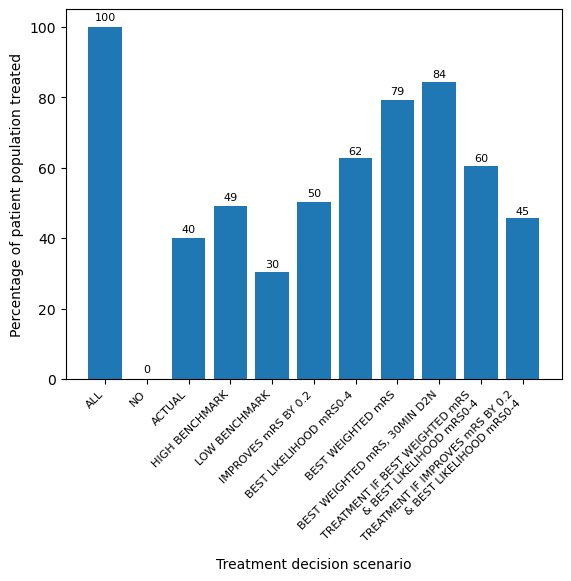

In [96]:
plot_bar(xticks, df_treatment_decision_per_scenario[columns].mean()*100);

Save results to file

In [97]:
# Model filename
filename = os.path.join(paths.data_save_path, 
                (paths.notebook + paths.model_text + '_scenario_treatment_decision_results.csv'))

df_treatment_decision_per_scenario.to_csv(filename)

### Store results: weighted mRS probability from their treatment decision
Initialise dataframe to store each patients weighted mRS score based on the treatment they got in each scenario 

In [98]:
df_weighted_mrs_per_scenario = pd.DataFrame()

df_weighted_mrs_per_scenario["All_treated"] = weighted_mrs_all_treated 
df_weighted_mrs_per_scenario["None_treated"] = weighted_mrs_none_treated
df_weighted_mrs_per_scenario["Actual_treatment_decision"] = weighted_mrs_actual_treatment
df_weighted_mrs_per_scenario["High_benchmark_treatment_decision"] = weighted_mrs_high_benchmark
df_weighted_mrs_per_scenario["Low_benchmark_treatment_decision"] = weighted_mrs_low_benchmark
df_weighted_mrs_per_scenario["Best_weighted_outcome"] = weighted_mrs_best_outcome
df_weighted_mrs_per_scenario["Best_weighted_outcome_30mins_d2n"] = weighted_mrs_best_outcome_30mins_d2n
df_weighted_mrs_per_scenario["Worst_weighted_outcome"] = weighted_mrs_worst_outcome
df_weighted_mrs_per_scenario["Best_proportion_outcome"] = weighted_mrs_best_proportion
df_weighted_mrs_per_scenario["Worst_proportion_outcome"] = weighted_mrs_worst_proportion
df_weighted_mrs_per_scenario["Best_weighted_outcome_and_proportion_outcome"] = weighted_mrs_best_outcome_and_proportion
df_weighted_mrs_per_scenario["Worst_weighted_outcome_and_proportion_outcome"] = weighted_mrs_worst_outcome_and_proportion
df_weighted_mrs_per_scenario["Threshold_improvement"] = weighted_mrs_threshold_improvement
df_weighted_mrs_per_scenario["Threshold_improvement_and_proportion_outcome"] = weighted_mrs_threshold_improvement_and_proportion

df_weighted_mrs_per_scenario.set_index(mask_all_treated.index, inplace=True)

Show the overview of this result, per scenario

In [99]:
df_weighted_mrs_per_scenario.describe()

,All_treated,None_treated,Actual_treatment_decision,High_benchmark_treatment_decision,Low_benchmark_treatment_decision,Best_weighted_outcome,Best_weighted_outcome_30mins_d2n,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome,Threshold_improvement,Threshold_improvement_and_proportion_outcome
count,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000,91394.000000
mean,2.651389,2.891425,2.734030,2.694270,2.744315,2.608477,2.573612,2.934337,2.637800,2.905014,2.635485,2.932022,2.637562,2.652752
std,1.357796,1.403144,1.392562,1.388962,1.396621,1.361176,1.355245,1.391164,1.349010,1.409149,1.348017,1.390694,1.363634,1.356047
min,0.149210,0.173077,0.165762,0.165762,0.165762,0.149210,0.131374,0.182353,0.173077,0.149210,0.173077,0.182353,0.173077,0.173077
25%,1.519686,1.704188,1.567702,1.533767,1.576549,1.475243,1.452067,1.759212,1.519693,1.708845,1.517556,1.756807,1.506784,1.530528
50%,2.332953,2.622090,2.416657,2.365351,2.423707,2.279055,2.242260,2.668804,2.317228,2.638826,2.314054,2.666756,2.303955,2.326020
75%,3.694754,4.071216,3.828316,3.769046,3.844123,3.651085,3.595475,4.100731,3.665660,4.093222,3.664363,4.099975,3.674930,3.681592
max,5.954798,5.968674,5.968674,5.968674,5.968674,5.930416,5.961012,5.968674,5.930416,5.968674,5.930416,5.968674,5.947256,5.947256


Create violin plot (range of weighted mRS scores for the population per treatment decision scenario)

In [100]:
def create_violin_plot(violin_data, xticks, y_label, ax=None, title=""):
    ax = ax or plt.gca()
    
    ax.violinplot(violin_data, showextrema=False, showmeans=True, widths=0.9)

    # customise the axes
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(columns) + 1))
    ax.set_xticklabels(xticks, rotation=45, fontsize=8, ha='right')

    ax.set_xlim(0.25, len(columns) + 0.75)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Treatment decision scenario', fontsize=12)
    ax.set_title(title, fontsize=12)

    return(ax)

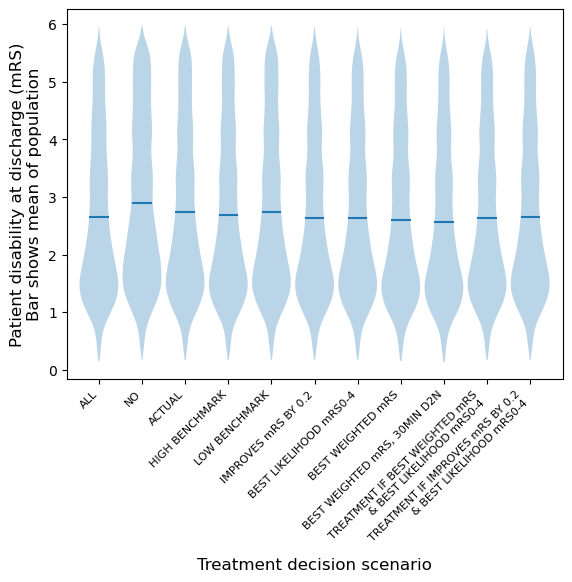

In [101]:
create_violin_plot(df_weighted_mrs_per_scenario[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population');

### Store results: probability of being mRS6
Initialise dataframe to store each patients probability of dying based on the treatment they got in each scenario 

In [102]:
df_mrs6_per_scenario = pd.DataFrame()

df_mrs6_per_scenario["All_treated"] = mrs6_all_treated 
df_mrs6_per_scenario["None_treated"] = mrs6_none_treated
df_mrs6_per_scenario["Actual_treatment_decision"] = mrs6_actual_treatment
df_mrs6_per_scenario["High_benchmark_treatment_decision"] = mrs6_high_benchmark
df_mrs6_per_scenario["Low_benchmark_treatment_decision"] = mrs6_low_benchmark
df_mrs6_per_scenario["Best_weighted_outcome"] = mrs6_best_outcome
df_mrs6_per_scenario["Best_weighted_outcome_30mins_d2n"] = mrs6_best_outcome_30mins_d2n
df_mrs6_per_scenario["Worst_weighted_outcome"] = mrs6_worst_outcome
df_mrs6_per_scenario["Best_proportion_outcome"] = mrs6_best_proportion
df_mrs6_per_scenario["Worst_proportion_outcome"] = mrs6_worst_proportion
df_mrs6_per_scenario["Best_weighted_outcome_and_proportion_outcome"] = mrs6_best_outcome_and_proportion
df_mrs6_per_scenario["Worst_weighted_outcome_and_proportion_outcome"] = mrs6_worst_outcome_and_proportion
df_mrs6_per_scenario["Threshold_improvement"] = mrs6_threshold_improvement
df_mrs6_per_scenario["Threshold_improvement_and_proportion_outcome"] = mrs6_threshold_improvement_and_proportion

df_mrs6_per_scenario.set_index(mask_all_treated.index, inplace=True)

Create violin plot (range of probability of dying for the population per treatment decision scenario)

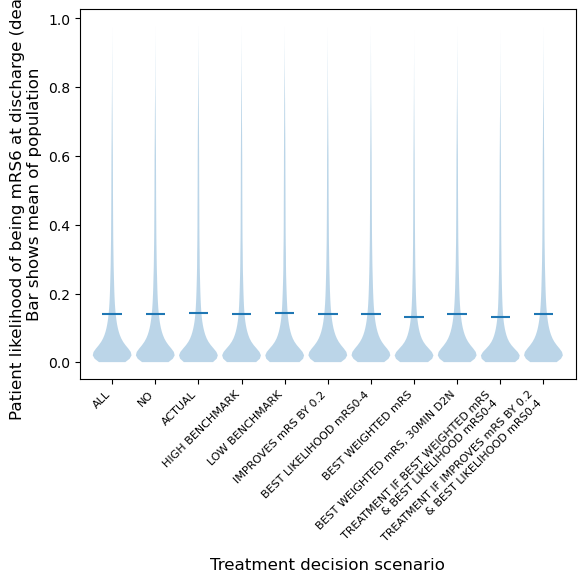

In [103]:
create_violin_plot(df_mrs6_per_scenario[columns], xticks, 
        'Patient likelihood of being mRS6 at discharge (death).\nBar shows '
        'mean of population');

Save results to file

In [104]:
# Model filename
filename = os.path.join(paths.data_save_path, 
    (paths.notebook + paths.model_text + '_scenario_weighted_mrs_results.csv'))

df_weighted_mrs_per_scenario.to_csv(filename)

Number of patients for who treatment did not change their weighted mRS

In [105]:
mask_weighted_mrs_indifferent_outcome.sum()

209

Number of patients for who treatment not change their likelihood being mRS0-4

In [106]:
mask_weighted_mrs_indifferent_proportion.sum()

209

# Questions to ask of the data

## Question 1. Is it largely an effect of stroke severity?

Would be expect to see a bigger shift in patient outcome with the more severe strokes?

Most of the strokes are mild severity. Expect that they will be receiving the least effect from thrombolysis treatment. This will weight the population outcome to appear as a smaller effect.

If look at subgroups of patients (say, moderate strokes, or severe stroke with no prior disability) we may see a larger effect.

Look at results for subgroups of patients

### 1. Subgroup: Patients with mild stroke

In [107]:
mask_mild = data["stroke_severity"] < 5

df_treatment_per_scenario_mild_stroke = (
    df_treatment_decision_per_scenario[mask_mild])

df_weighted_mrs_per_scenario_mild_stroke = (
            df_weighted_mrs_per_scenario[mask_mild])

df_mrs6_per_scenario_mild_stroke = (
            df_mrs6_per_scenario[mask_mild])

### 2. Subgroup: Patients with moderate stroke

In [108]:
mask_moderate = (data["stroke_severity"] > 4) & (data["stroke_severity"] < 21)

df_treatment_per_scenario_moderate_stroke = (
    df_treatment_decision_per_scenario[mask_moderate])

df_weighted_mrs_per_scenario_moderate_stroke = (
    df_weighted_mrs_per_scenario[mask_moderate])

df_mrs6_per_scenario_moderate_stroke = (
            df_mrs6_per_scenario[mask_moderate])

### 3. Subgroup: Patients with severe stroke

In [109]:
mask_severe = data["stroke_severity"] > 20

df_treatment_per_scenario_severe_stroke = (
    df_treatment_decision_per_scenario[mask_severe])

df_weighted_mrs_per_scenario_severe_stroke = (
    df_weighted_mrs_per_scenario[mask_severe])

df_mrs6_per_scenario_severe_stroke = (
            df_mrs6_per_scenario[mask_severe])

### 4. Subgroup: Patients with severe stroke with no prior disability

In [110]:
mask_severe = data["stroke_severity"] > 20
mask_no_prior_disability = data["prior_disability"] <2
mask = mask_severe * mask_no_prior_disability

df_treatment_per_scenario_severe_stroke_no_prior_disability = (
    df_treatment_decision_per_scenario[mask])

df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability = (
    df_weighted_mrs_per_scenario[mask])

df_mrs6_per_scenario_severe_stroke_no_prior_disability = (
            df_mrs6_per_scenario[mask])

Show each of these patient subgroups in their own bar plot

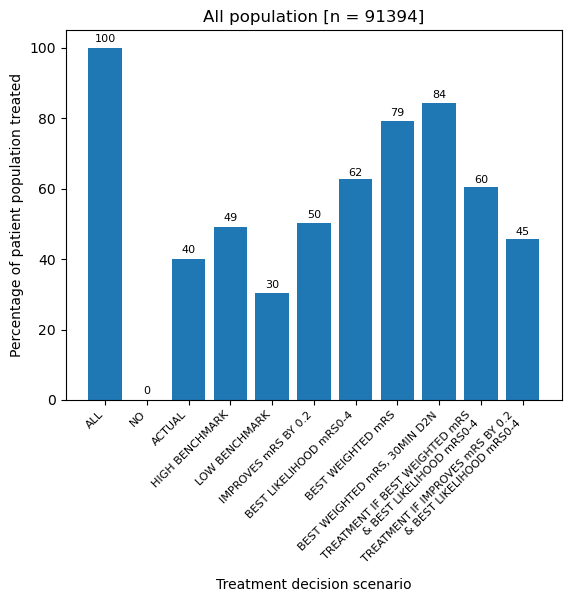

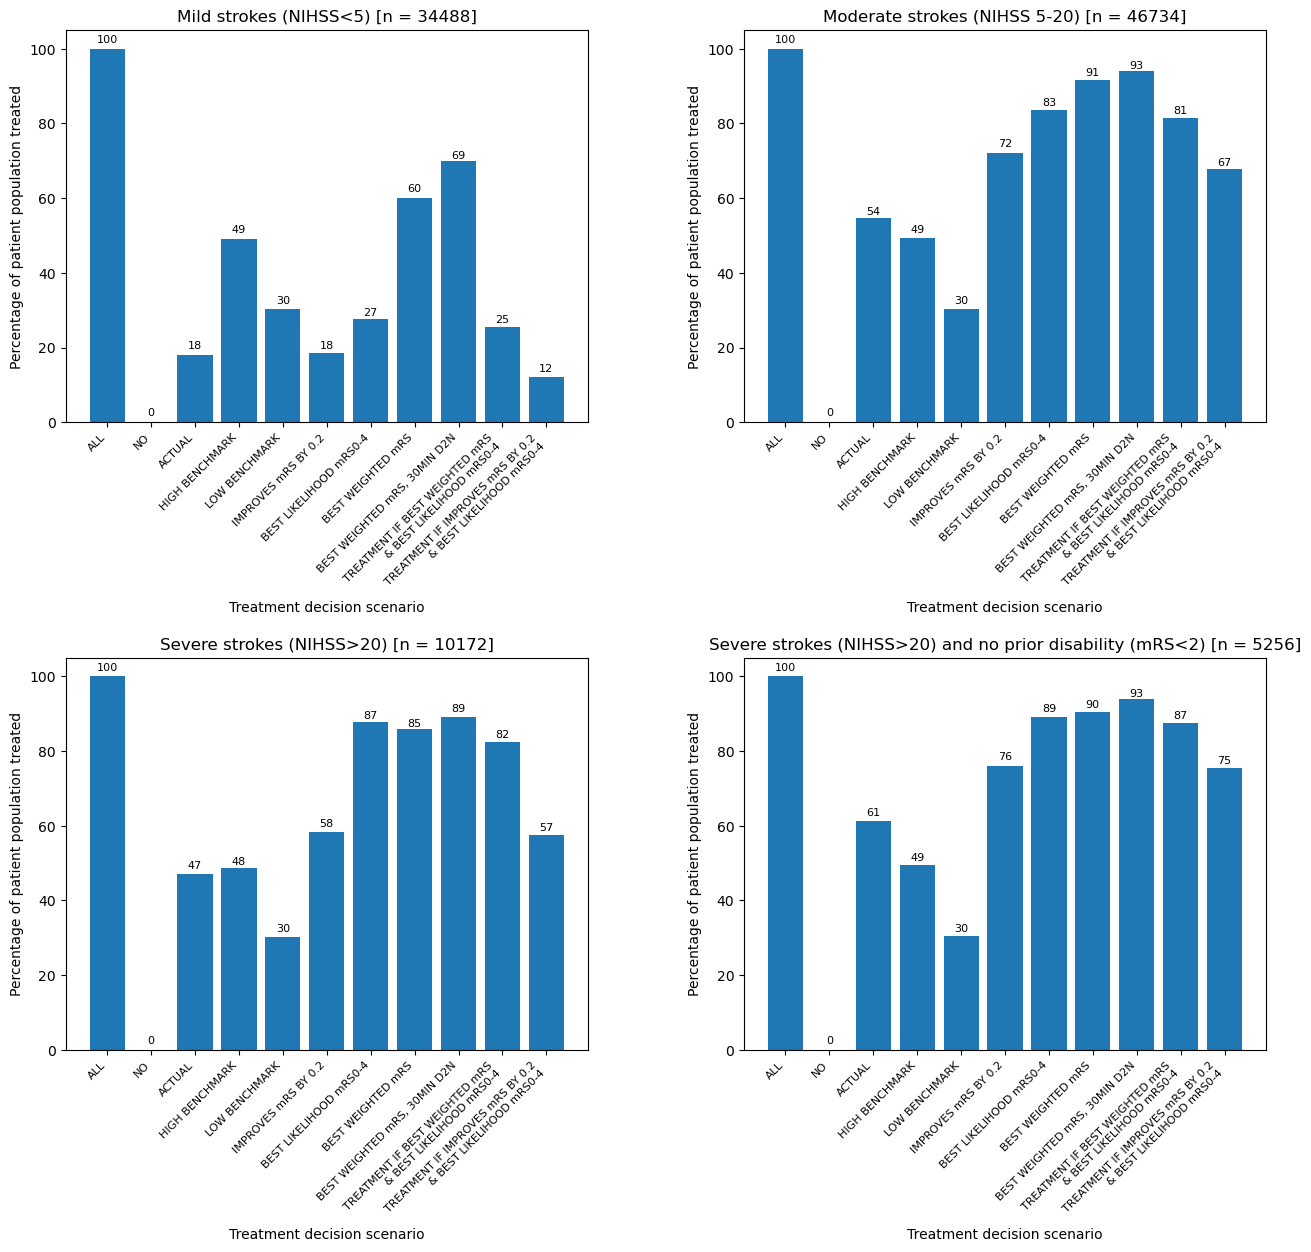

In [111]:
n_patients = df_treatment_decision_per_scenario.shape[0]
title = f"All population [n = {n_patients}]"
plot_bar(xticks, df_treatment_decision_per_scenario[columns].mean()*100, title=title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 12))

n_patients = df_treatment_per_scenario_mild_stroke.shape[0]
title = f"Mild strokes (NIHSS<5) [n = {n_patients}]"
plot_bar(xticks, df_treatment_per_scenario_mild_stroke[columns].mean()*100, ax1, title=title)

n_patients = df_treatment_per_scenario_moderate_stroke.shape[0]
title = f"Moderate strokes (NIHSS 5-20) [n = {n_patients}]"
plot_bar(xticks, df_treatment_per_scenario_moderate_stroke[columns].mean()*100, ax2, title=title)

n_patients = df_treatment_per_scenario_severe_stroke.shape[0]
title = f"Severe strokes (NIHSS>20) [n = {n_patients}]"
plot_bar(xticks, df_treatment_per_scenario_severe_stroke[columns].mean()*100, ax3, title=title)

n_patients = df_treatment_per_scenario_severe_stroke_no_prior_disability.shape[0]
title = f"Severe strokes (NIHSS>20) and no prior disability (mRS<2) [n = {n_patients}]"
plot_bar(xticks, df_treatment_per_scenario_severe_stroke_no_prior_disability[columns].mean()*100, ax4, title=title)

fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=0.95, wspace=0.3, hspace=0.6)
plt.show()

Show each of these patient subgroups in their own violin plot

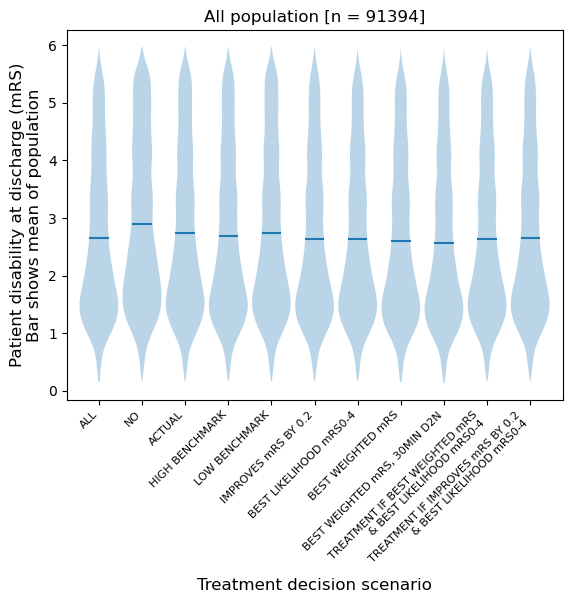

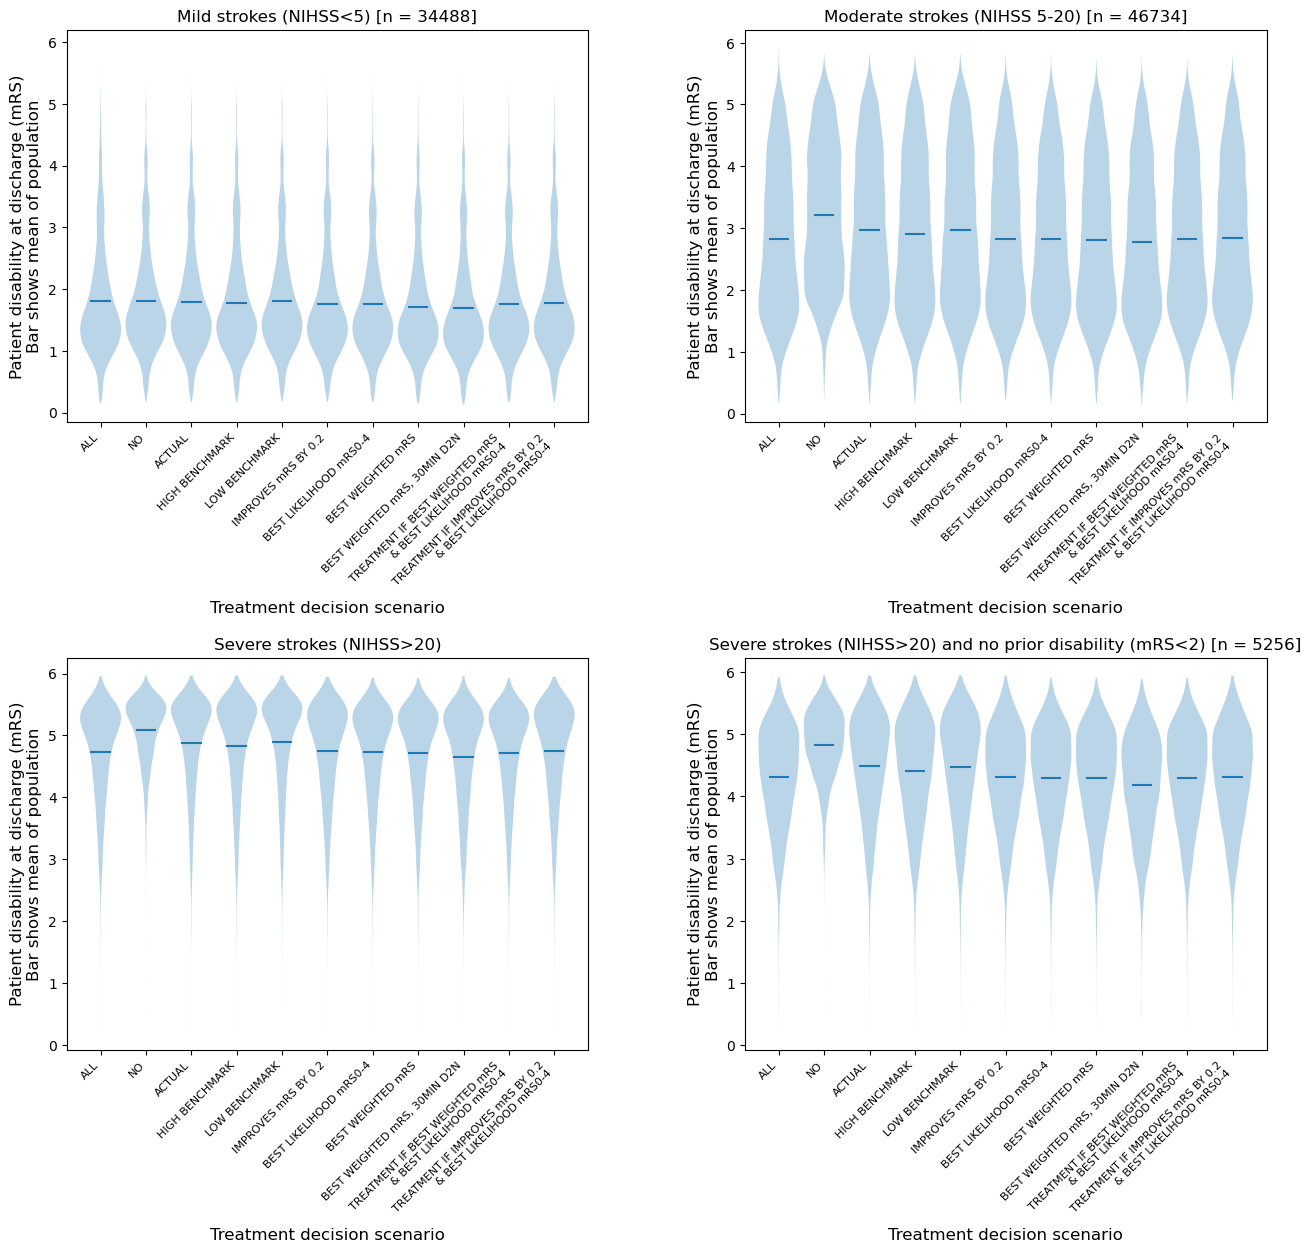

In [112]:
n_patients = df_weighted_mrs_per_scenario.shape[0]
title = f"All population [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        title=title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 12))

n_patients = df_weighted_mrs_per_scenario_mild_stroke.shape[0]
title = f"Mild strokes (NIHSS<5) [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario_mild_stroke[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        ax1, title=title)

n_patients = df_weighted_mrs_per_scenario_moderate_stroke.shape[0]
title = f"Moderate strokes (NIHSS 5-20) [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario_moderate_stroke[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        ax2, title=title)

n_patients = df_weighted_mrs_per_scenario_severe_stroke.shape[0]
title = f"Severe strokes (NIHSS>20) [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario_severe_stroke[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        ax3, title="Severe strokes (NIHSS>20)")

n_patients = df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability.shape[0]
title = f"Severe strokes (NIHSS>20) and no prior disability (mRS<2) [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        ax4, title=title)

fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=0.95, wspace=0.3, hspace=0.6)
plt.show()

Show each of these patient subgroups in their own violin plot

NameError: name 'ax' is not defined

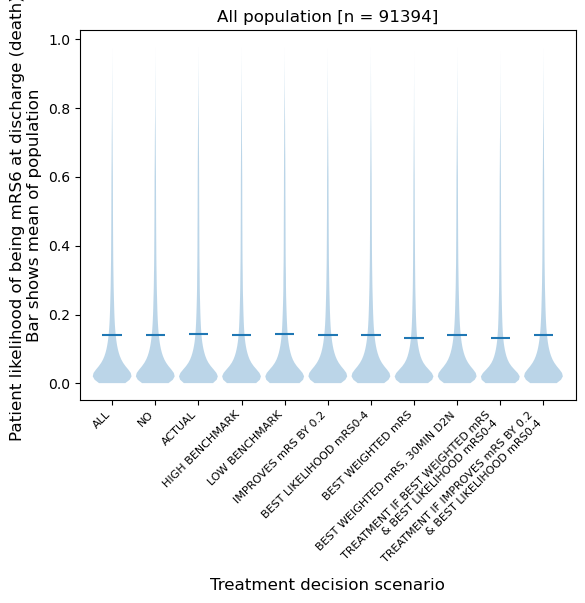

In [113]:
n_patients = df_mrs6_per_scenario.shape[0]
title = f"All population [n = {n_patients}]"
create_violin_plot(df_mrs6_per_scenario[columns], xticks, 
        'Patient likelihood of being mRS6 at discharge (death).\nBar shows mean of population',
        title=title)
ax.set_ylim((0,1))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 12))

n_patients = df_mrs6_per_scenario_mild_stroke.shape[0]
title = f"Mild strokes (NIHSS<5) [n = {n_patients}]"
create_violin_plot(df_mrs6_per_scenario_mild_stroke[columns], xticks, 
        'Patient likelihood of being mRS6 at discharge (death).\nBar shows mean of population',
        ax1, title=title)
ax1.set_ylim((0,1))

n_patients = df_mrs6_per_scenario_moderate_stroke.shape[0]
title = f"Moderate strokes (NIHSS 5-20) [n = {n_patients}]"
create_violin_plot(df_mrs6_per_scenario_moderate_stroke[columns], xticks, 
        'Patient likelihood of being mRS6 at discharge (death).\nBar shows mean of population',
        ax2, title=title)
ax2.set_ylim((0,1))

n_patients = df_mrs6_per_scenario_severe_stroke.shape[0]
title = f"Severe strokes (NIHSS>20) [n = {n_patients}]"
create_violin_plot(df_mrs6_per_scenario_severe_stroke[columns], xticks, 
        'Patient likelihood of being mRS6 at discharge (death).\nBar shows mean of population',
        ax3, title=title)
ax3.set_ylim((0,1))

n_patients = df_mrs6_per_scenario_severe_stroke_no_prior_disability.shape[0]
title = f"Severe strokes (NIHSS>20) and no prior disability (mRS<2) [n = {n_patients}]"
create_violin_plot(df_mrs6_per_scenario_severe_stroke_no_prior_disability[columns], xticks, 
        'Patient likelihood of being mRS6 at discharge (death).\nBar shows mean of population',
        ax4, title=title)
ax4.set_ylim((0,1))

fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=0.95, wspace=0.3, hspace=0.6)
plt.show()

## Question 2: Is there a bigger effect of treatment for patients with a worse predicted outcome without treatment

For each patient calculate the benefit they receive due to treatment ("Difference in weighted mRS when have treatment"). A negative value represents a reduction in mRS due to treatment - this is an improvement.

Plot this against "Weighted mRS without treatment".

If there is a larger treatment benefit for those with a higher mRS without treatment, the relationship will show the patients with a larger "Weighted mRS without treatment", will have a lower (more negative) "Difference in weighted mRS when have treatment".

Look at this for all the patients, and per subgroups based on their prior disability level.

In [ ]:
def fit_logstic_regression(x, y):
    # Get r-square of predicted thrombolysis rate.
    slr = LinearRegression()
    slr.fit(x, y)
    y_pred = slr.predict(x)
    r_square = metrics.r2_score(y, y_pred)
    return(slr, r_square)

In [ ]:
def plot_scatter(x, y, slr, r_square, ax, x_min, x_max, y_min, y_max, xlabel, 
                 ylabel, title):
    
    ax.scatter(x, y, s=0.2, c="k", alpha=0.3)

    plt.plot (x, slr.predict(x), color = 'grey', linewidth=0.8, linestyle="--")
    
    x_range = x_max - x_min
    text = f'R squared: {r_square:.3f}'
    ax.text((x_min + x_range/20), y_min*0.9, text, 
             bbox=dict(facecolor='white', edgecolor='white'))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"For patients with prior disability mRS: {title}")
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)

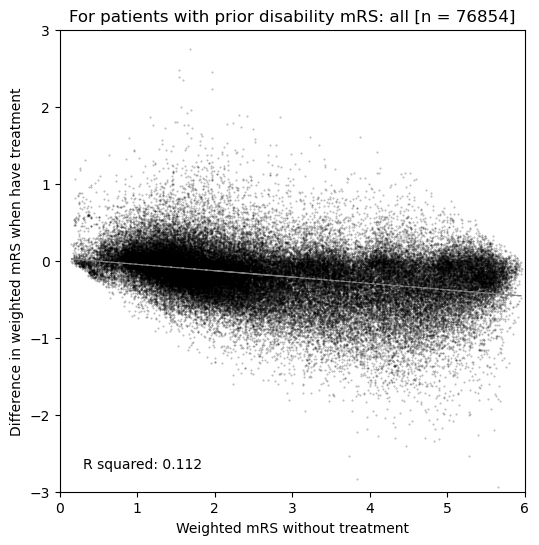

In [ ]:
x = weighted_mrs_none_treated.reshape(-1, 1)

predicted_mrs_shift_due_to_thrombolysis = (
                        weighted_mrs_all_treated - weighted_mrs_none_treated)
y = predicted_mrs_shift_due_to_thrombolysis.reshape(-1, 1)

x_min = round(x.min(),0)
x_max = round(x.max(),0)
y_min = round(y.min(),0)
y_max = round(y.max(),0)

# The full dataset
(slr, r_square) = fit_logstic_regression(x, y)

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

n_patients = x.shape[0]
title = f"all [n = {n_patients}]"
plot_scatter(x, y, slr, r_square, ax1, x_min, x_max, y_min, y_max, 
             "Weighted mRS without treatment", 
             "Difference in weighted mRS when have treatment", title)

Per prior disabiliy

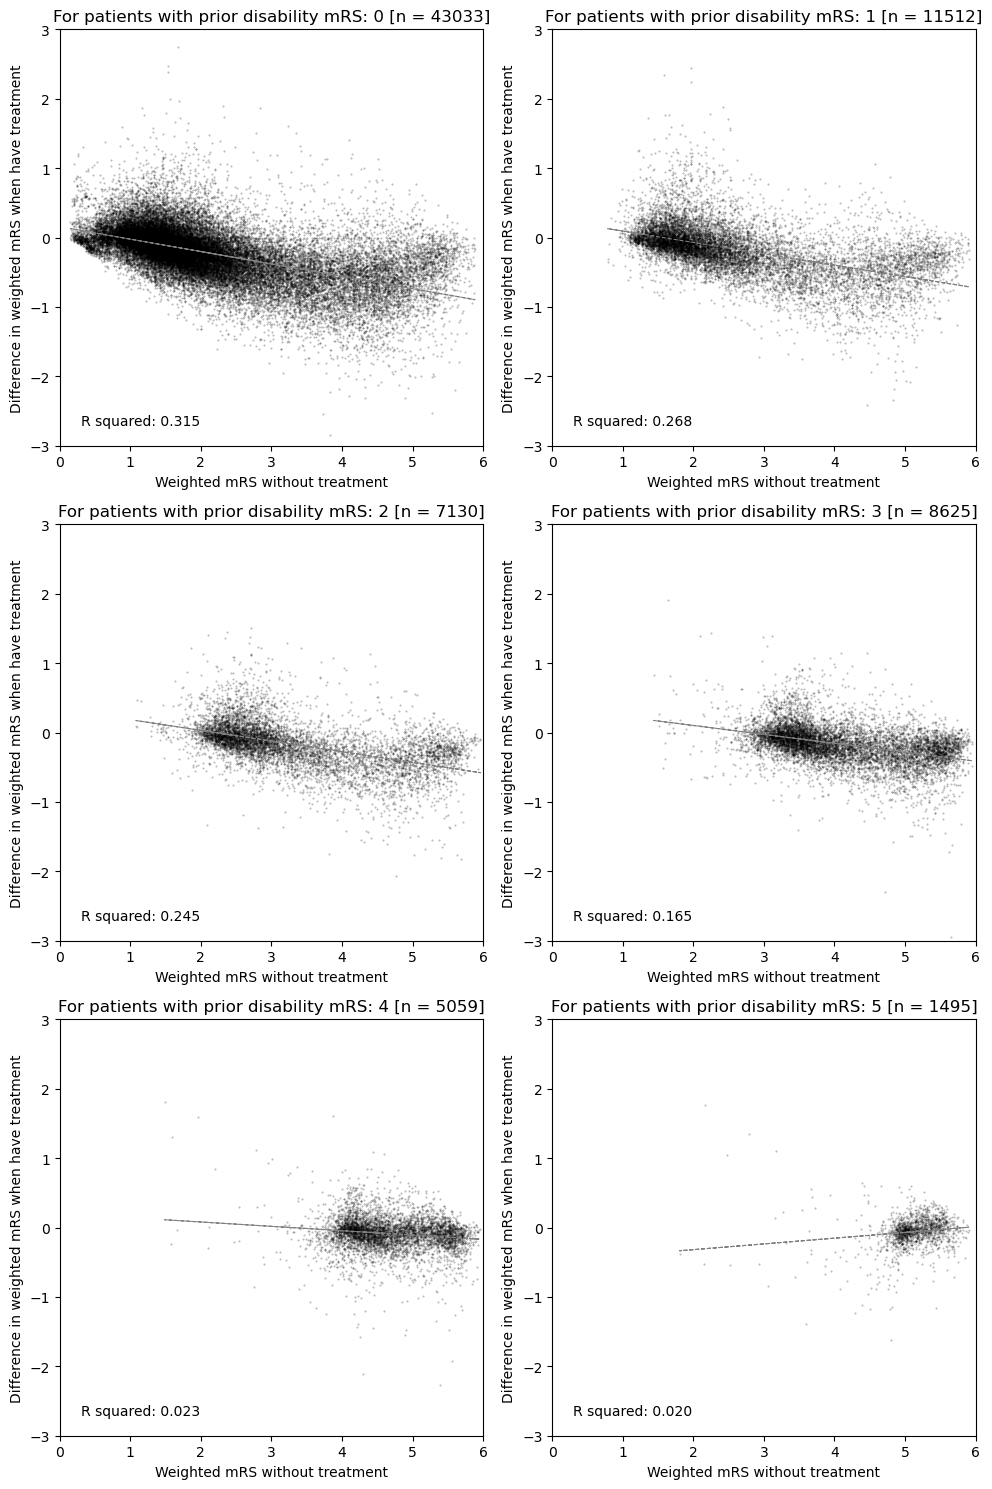

In [ ]:
fig = plt.figure(figsize=(10,15))

for subplot, prior_disability in enumerate(list(set(data["prior_disability"]))):
    mask = data["prior_disability"] == prior_disability
    x = weighted_mrs_none_treated[mask].reshape(-1, 1)
    y = predicted_mrs_shift_due_to_thrombolysis[mask].reshape(-1, 1)

    # The full dataset
    (slr, r_square) = fit_logstic_regression(x, y)

    ax1 = fig.add_subplot(3,2,subplot+1)

    n_patients = x.shape[0]
    title = f"{prior_disability} [n = {n_patients}]"
    plot_scatter(x, y, slr, r_square, ax1, x_min, x_max, y_min, y_max, 
                 "Weighted mRS without treatment", 
                 "Difference in weighted mRS when have treatment", 
                 title)
    
fig.tight_layout()

## Question 3: Which type of patients have indifferent outcomes with treatment?

Where's the break even point?

In [ ]:
patient_in_both = (
    mask_weighted_mrs_indifferent_outcome == mask_weighted_mrs_indifferent_proportion)
percent_matched = (patient_in_both.sum()/mask_weighted_mrs_indifferent_outcome.shape[0] * 100)
print(f"Of the patients that have an indifferent weighted mRS proportion due to treatment"
      f", {round(percent_matched)}% of them also have an indifferent outcome")

Of the patients that have an indifferent weighted mRS proportion due to treatment, 100% of them also have an indifferent outcome


As they are the same patient subgroup, the followig results are for the same patient subgroup.

Describe the patient characteristics that have indifferent outcome based on treatment

In [ ]:
data[mask_weighted_mrs_indifferent_outcome].describe()

,precise_onset_known,discharge_disability,any_afib_diagnosis,stroke_severity,onset_during_sleep,onset_to_arrival_time,arrival_to_scan_time,age,onset_to_thrombolysis_time,prior_disability,...,team_Whiston Hospital HASU,team_William Harvey Hospital,team_Wirral Arrowe Park Hospital,team_Withybush General Hospital,team_Worcestershire Royal Hospital,team_Worthing Hospital,team_Wycombe General Hospital,team_Yeovil District Hospital,team_York Hospital,team_Ysbyty Gwynedd
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,...,177.000000,177.0,177.0,177.0,177.0,177.000000,177.000000,177.000000,177.000000,177.0
mean,0.779661,2.254237,0.124294,8.711864,0.011299,16.683616,11.248588,72.923729,0.395480,0.621469,...,0.022599,0.0,0.0,0.0,0.0,0.005650,0.011299,0.005650,0.005650,0.0
std,0.415651,1.935845,0.330852,6.584376,0.105996,12.209879,8.256217,12.956049,67.246676,1.171728,...,0.149042,0.0,0.0,0.0,0.0,0.075165,0.105996,0.075165,0.075165,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,37.500000,-100.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,1.000000,0.000000,4.000000,0.000000,6.000000,5.000000,67.500000,-100.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,2.000000,0.000000,7.000000,0.000000,15.000000,10.000000,72.500000,40.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,3.000000,0.000000,12.000000,0.000000,25.000000,16.000000,82.500000,50.000000,1.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,6.000000,1.000000,27.000000,1.000000,48.000000,51.000000,92.500000,55.000000,5.000000,...,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0


In [ ]:
data[mask_weighted_mrs_indifferent_proportion].describe()

,precise_onset_known,discharge_disability,any_afib_diagnosis,stroke_severity,onset_during_sleep,onset_to_arrival_time,arrival_to_scan_time,age,onset_to_thrombolysis_time,prior_disability,...,team_Whiston Hospital HASU,team_William Harvey Hospital,team_Wirral Arrowe Park Hospital,team_Withybush General Hospital,team_Worcestershire Royal Hospital,team_Worthing Hospital,team_Wycombe General Hospital,team_Yeovil District Hospital,team_York Hospital,team_Ysbyty Gwynedd
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,...,177.000000,177.0,177.0,177.0,177.0,177.000000,177.000000,177.000000,177.000000,177.0
mean,0.779661,2.254237,0.124294,8.711864,0.011299,16.683616,11.248588,72.923729,0.395480,0.621469,...,0.022599,0.0,0.0,0.0,0.0,0.005650,0.011299,0.005650,0.005650,0.0
std,0.415651,1.935845,0.330852,6.584376,0.105996,12.209879,8.256217,12.956049,67.246676,1.171728,...,0.149042,0.0,0.0,0.0,0.0,0.075165,0.105996,0.075165,0.075165,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,37.500000,-100.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,1.000000,0.000000,4.000000,0.000000,6.000000,5.000000,67.500000,-100.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,2.000000,0.000000,7.000000,0.000000,15.000000,10.000000,72.500000,40.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,3.000000,0.000000,12.000000,0.000000,25.000000,16.000000,82.500000,50.000000,1.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,6.000000,1.000000,27.000000,1.000000,48.000000,51.000000,92.500000,55.000000,5.000000,...,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0


### What's the patient overlap (in terms of characteristics) between the two patients groups that get IVT: Scenario ACTUAL and Scenario IMPROVES mRS 0.2


1) Which patient characteristics get treatment in the scenario "Best Weighted mRS"?
2) Which patient characteristics get treatment in the scenario “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4”?
3) Which patient characteristics get treatment in the scenario "Best Weighted mRS", but not in “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4”? (The patients getting treatment in the Scenario “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4” is a subset of the scenario Best Weighted mRS)
4) Which patient characteristics get treatment in the scenario "ACTUAL", and “TREATMENT IF IMPROVES mRS BY 0.2"

Use pd.describe

#### Subgroup 1) Which patient characteristics get treatment in the scenario "Best Weighted mRS"?

In [ ]:
in_scenario = "Best_weighted_outcome"
mask_treated_in_scenario = df_treatment_decision_per_scenario[in_scenario] == 1

# Number of patients in this subgroup
n_s1 = mask_treated_in_scenario.sum()

df_subgroup1 = data[mask_treated_in_scenario].describe()
df_subgroup1

,precise_onset_known,discharge_disability,any_afib_diagnosis,stroke_severity,onset_during_sleep,onset_to_arrival_time,arrival_to_scan_time,age,onset_to_thrombolysis_time,prior_disability,...,team_Whiston Hospital HASU,team_William Harvey Hospital,team_Wirral Arrowe Park Hospital,team_Withybush General Hospital,team_Worcestershire Royal Hospital,team_Worthing Hospital,team_Wycombe General Hospital,team_Yeovil District Hospital,team_York Hospital,team_Ysbyty Gwynedd
count,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,...,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000,57299.000000
mean,0.676888,2.723643,0.168799,9.935828,0.041833,102.190824,27.100124,74.319927,27.676940,1.021414,...,0.013159,0.004014,0.009564,0.002915,0.010279,0.009267,0.012094,0.005969,0.011414,0.003909
std,0.467669,1.945992,0.374577,7.474285,0.200210,45.746374,23.599902,13.375289,132.005746,1.396759,...,0.113957,0.063230,0.097327,0.053908,0.100866,0.095820,0.109309,0.077027,0.106225,0.062403
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,37.500000,-100.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,4.000000,0.000000,68.000000,12.000000,67.500000,-100.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,8.000000,0.000000,93.000000,21.000000,77.500000,63.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,0.000000,15.000000,0.000000,128.000000,34.000000,82.500000,147.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,6.000000,1.000000,42.000000,1.000000,254.000000,236.000000,92.500000,706.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Subgroup 2) Which patient characteristics get treatment in the scenario “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4”?

In [ ]:
in_scenario = "Threshold_improvement_and_proportion_outcome"
mask_treated_in_scenario = df_treatment_decision_per_scenario[in_scenario] == 1

# Number of patients in this subgroup
n_s2 = mask_treated_in_scenario.sum()

df_subgroup2 = data[mask_treated_in_scenario].describe()
df_subgroup2

,precise_onset_known,discharge_disability,any_afib_diagnosis,stroke_severity,onset_during_sleep,onset_to_arrival_time,arrival_to_scan_time,age,onset_to_thrombolysis_time,prior_disability,...,team_Whiston Hospital HASU,team_William Harvey Hospital,team_Wirral Arrowe Park Hospital,team_Withybush General Hospital,team_Worcestershire Royal Hospital,team_Worthing Hospital,team_Wycombe General Hospital,team_Yeovil District Hospital,team_York Hospital,team_Ysbyty Gwynedd
count,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,...,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000,30894.000000
mean,0.664919,2.953972,0.187836,12.659157,0.041529,96.587784,25.156309,74.585356,51.115039,0.892989,...,0.011038,0.003722,0.008675,0.002104,0.008481,0.010196,0.012365,0.004758,0.012300,0.004078
std,0.472026,1.990156,0.390587,7.091699,0.199514,44.186166,21.798498,13.145237,126.232153,1.272329,...,0.104481,0.060899,0.092735,0.045821,0.091700,0.100462,0.110510,0.068817,0.110224,0.063734
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,37.500000,-100.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,7.000000,0.000000,65.000000,12.000000,67.500000,-100.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,3.000000,0.000000,11.000000,0.000000,87.000000,20.000000,77.500000,103.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,5.000000,0.000000,18.000000,0.000000,120.000000,32.000000,82.500000,150.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,6.000000,1.000000,42.000000,1.000000,254.000000,236.000000,92.500000,645.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Subgroup 3) Which patient characteristics get treatment in the scenario "Best Weighted mRS", but not in “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4”?

In [ ]:
in_scenario = "Best_weighted_outcome"
out_scenario = "Threshold_improvement_and_proportion_outcome"

mask_treated_in_scenario = df_treatment_decision_per_scenario[in_scenario] == 1
mask_not_treated_in_scenario = df_treatment_decision_per_scenario[out_scenario] == 0
mask = mask_treated_in_scenario * mask_not_treated_in_scenario

# Number of patients in this subgroup
n_s3 = mask.sum()

df_subgroup3 = data[mask].describe()
df_subgroup3

,precise_onset_known,discharge_disability,any_afib_diagnosis,stroke_severity,onset_during_sleep,onset_to_arrival_time,arrival_to_scan_time,age,onset_to_thrombolysis_time,prior_disability,...,team_Whiston Hospital HASU,team_William Harvey Hospital,team_Wirral Arrowe Park Hospital,team_Withybush General Hospital,team_Worcestershire Royal Hospital,team_Worthing Hospital,team_Wycombe General Hospital,team_Yeovil District Hospital,team_York Hospital,team_Ysbyty Gwynedd
count,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,...,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000,26405.000000
mean,0.690892,2.454156,0.146525,6.749517,0.042189,108.746412,29.374399,74.009373,0.254232,1.171672,...,0.015641,0.004355,0.010604,0.003863,0.012384,0.008180,0.011778,0.007385,0.010377,0.003711
std,0.462135,1.857132,0.353639,6.599739,0.201024,46.661210,25.358777,13.633217,133.326010,1.515821,...,0.124084,0.065852,0.102430,0.062033,0.110594,0.090076,0.107888,0.085620,0.101339,0.060809
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,37.500000,-100.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,3.000000,0.000000,74.000000,13.000000,67.500000,-100.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,4.000000,0.000000,100.000000,23.000000,77.500000,-100.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,0.000000,8.000000,0.000000,137.000000,37.000000,82.500000,142.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,6.000000,1.000000,42.000000,1.000000,254.000000,229.000000,92.500000,706.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Subgroup 4) Which patient characteristics get treatment in the scenario "ACTUAL", and “TREATMENT IF IMPROVES mRS BY 0.2"

In [ ]:
in_scenario1 = "Actual_treatment_decision"
in_scenario2 = "Threshold_improvement_and_proportion_outcome"

mask_treated_in_scenario1 = df_treatment_decision_per_scenario[in_scenario1] == 1
mask_treated_in_scenario2 = df_treatment_decision_per_scenario[in_scenario2] == 1
mask = mask_treated_in_scenario1 * mask_treated_in_scenario2

# Number of patients in this subgroup
n_s4 = mask.sum()

df_subgroup4 = data[mask].describe()
df_subgroup4

,precise_onset_known,discharge_disability,any_afib_diagnosis,stroke_severity,onset_during_sleep,onset_to_arrival_time,arrival_to_scan_time,age,onset_to_thrombolysis_time,prior_disability,...,team_Whiston Hospital HASU,team_William Harvey Hospital,team_Wirral Arrowe Park Hospital,team_Withybush General Hospital,team_Worcestershire Royal Hospital,team_Worthing Hospital,team_Wycombe General Hospital,team_Yeovil District Hospital,team_York Hospital,team_Ysbyty Gwynedd
count,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,...,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000
mean,0.800042,2.583325,0.171090,12.943534,0.005710,91.881305,20.224278,73.133393,146.830284,0.639262,...,0.011367,0.002696,0.007508,0.002644,0.008142,0.011367,0.014064,0.005499,0.013165,0.003119
std,0.399979,1.912997,0.376598,6.498566,0.075351,41.263189,14.963794,13.075158,49.002656,1.063412,...,0.106012,0.051858,0.086323,0.051349,0.089868,0.106012,0.117757,0.073950,0.113983,0.055766
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,37.500000,56.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,8.000000,0.000000,62.000000,10.000000,62.500000,110.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,12.000000,0.000000,83.000000,17.000000,77.500000,138.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,0.000000,18.000000,0.000000,112.000000,26.000000,82.500000,178.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,6.000000,1.000000,40.000000,1.000000,253.000000,186.000000,92.500000,645.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_mean_per_subgroup = pd.DataFrame()
df_mean_per_subgroup["Treated_in_Best_weighted_outcome"] = df_subgroup1.loc["mean"]
df_mean_per_subgroup["Treated_in_Threshold_improvement_and_proportion_outcome"] = df_subgroup2.loc["mean"]
df_mean_per_subgroup["Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome"] = df_subgroup3.loc["mean"]
df_mean_per_subgroup["Treated_in_Actual_and_Proportion_outcome"] = df_subgroup4.loc["mean"]
df_mean_per_subgroup.head(10).round(2)

,Treated_in_Best_weighted_outcome,Treated_in_Threshold_improvement_and_proportion_outcome,Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome,Treated_in_Actual_and_Proportion_outcome
precise_onset_known,0.68,0.66,0.69,0.80
discharge_disability,2.72,2.95,2.45,2.58
any_afib_diagnosis,0.17,0.19,0.15,0.17
stroke_severity,9.94,12.66,6.75,12.94
onset_during_sleep,0.04,0.04,0.04,0.01
onset_to_arrival_time,102.19,96.59,108.75,91.88
arrival_to_scan_time,27.10,25.16,29.37,20.22
age,74.32,74.59,74.01,73.13
onset_to_thrombolysis_time,27.68,51.12,0.25,146.83
prior_disability,1.02,0.89,1.17,0.64


In [ ]:
df_mean_per_subgroup = pd.DataFrame()
df_mean_per_subgroup[f"Best weighted mRS [n={n_s1}]"] = df_subgroup1.loc["mean"]
df_mean_per_subgroup[f"Improves mRS by 0.2 & Best likelihood mRS0-4 [n={n_s2}]"] = df_subgroup2.loc["mean"]
df_mean_per_subgroup[f"Best weighted mRS, but NOT in Improves mRS by 0.2 and best likelihood mRS0-4 [n={n_s3}]"] = df_subgroup3.loc["mean"]
df_mean_per_subgroup[f"Actual & Improves mRS by 0.2 [n={n_s4}]"] = df_subgroup4.loc["mean"]
df_mean_per_subgroup.head(10).round(2)

,Best weighted mRS [n=57299],Improves mRS by 0.2 & Best likelihood mRS0-4 [n=30894],"Best weighted mRS, but NOT in Improves mRS by 0.2 and best likelihood mRS0-4 [n=26405]",Actual & Improves mRS by 0.2 [n=18914]
precise_onset_known,0.68,0.66,0.69,0.80
discharge_disability,2.72,2.95,2.45,2.58
any_afib_diagnosis,0.17,0.19,0.15,0.17
stroke_severity,9.94,12.66,6.75,12.94
onset_during_sleep,0.04,0.04,0.04,0.01
onset_to_arrival_time,102.19,96.59,108.75,91.88
arrival_to_scan_time,27.10,25.16,29.37,20.22
age,74.32,74.59,74.01,73.13
onset_to_thrombolysis_time,27.68,51.12,0.25,146.83
prior_disability,1.02,0.89,1.17,0.64


In [ ]:
in_scenario1 = "Actual_treatment_decision"
in_scenario2 = "Threshold_improvement_and_proportion_outcome"

mask_treated_in_scenario1 = df_treatment_decision_per_scenario[in_scenario1] == 1
mask_treated_in_scenario2 = df_treatment_decision_per_scenario[in_scenario2] == 1
mask = mask_treated_in_scenario1 * mask_treated_in_scenario2

In [ ]:
data[mask]#.describe()


,precise_onset_known,discharge_disability,any_afib_diagnosis,stroke_severity,onset_during_sleep,onset_to_arrival_time,arrival_to_scan_time,age,onset_to_thrombolysis_time,prior_disability,...,team_Whiston Hospital HASU,team_William Harvey Hospital,team_Wirral Arrowe Park Hospital,team_Withybush General Hospital,team_Worcestershire Royal Hospital,team_Worthing Hospital,team_Wycombe General Hospital,team_Yeovil District Hospital,team_York Hospital,team_Ysbyty Gwynedd
1,1,2.0,0.0,12,0,170.0,7.0,77.5,272.0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1.0,0.0,10,0,50.0,27.0,62.5,115.0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,4.0,0.0,14,0,84.0,7.0,87.5,131.0,3,...,0,0,0,0,0,0,0,0,0,0
19,1,3.0,0.0,15,0,155.0,1.0,87.5,220.0,0,...,0,0,0,0,0,0,0,1,0,0
25,1,3.0,0.0,13,0,115.0,10.0,47.5,136.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146682,1,0.0,0.0,15,0,165.0,16.0,77.5,194.0,0,...,0,0,0,0,0,0,0,0,0,0
146691,1,1.0,1.0,18,0,69.0,20.0,67.5,120.0,0,...,0,0,0,0,0,0,0,0,0,0
146698,1,1.0,0.0,15,0,68.0,17.0,47.5,116.0,0,...,0,0,0,0,0,0,0,0,0,0
146699,1,0.0,1.0,12,0,83.0,23.0,67.5,124.0,0,...,0,0,0,0,0,0,0,0,0,0


How many of these patients 

In [ ]:
def multiple_bar_plot(ax, dict_plot, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Code source:
    https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(dict_plot)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(dict_plot.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, dict_plot.keys(), loc='best', bbox_to_anchor=(1.02,0.2,0,0), fontsize=6)

In [ ]:
#ohe_stroke_team_features
df_mean_per_subgroup.loc[ohe_stroke_team_features]#.max().max()*105

,Treated_in_Best_weighted_outcome,Treated_in_Threshold_improvement_and_proportion_outcome,Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome,Treated_in_Actual_and_Proportion_outcome
team_Addenbrooke's Hospital,0.011030,0.012041,0.009847,0.012266
team_Basildon University Hospital,0.008203,0.010779,0.005188,0.011420
team_Blackpool Victoria Hospital,0.006614,0.006377,0.006893,0.005974
team_Bradford and Airedale SU,0.005899,0.006215,0.005529,0.006450
team_Bronglais Hospital,0.002199,0.002266,0.002121,0.003172
...,...,...,...,...
team_Worthing Hospital,0.009267,0.010196,0.008180,0.011367
team_Wycombe General Hospital,0.012094,0.012365,0.011778,0.014064
team_Yeovil District Hospital,0.005969,0.004758,0.007385,0.005499
team_York Hospital,0.011414,0.012300,0.010377,0.013165


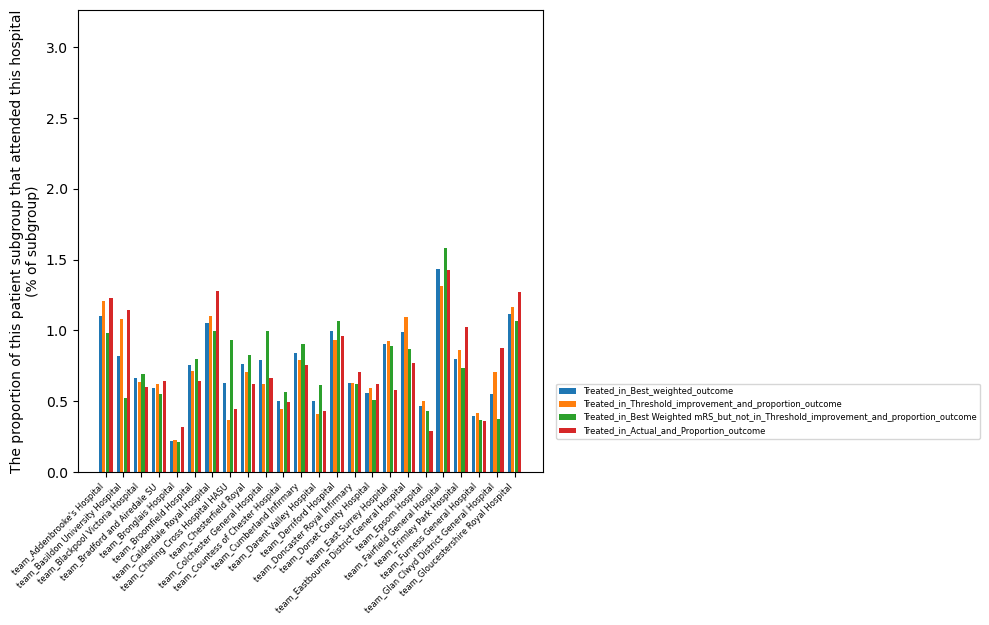

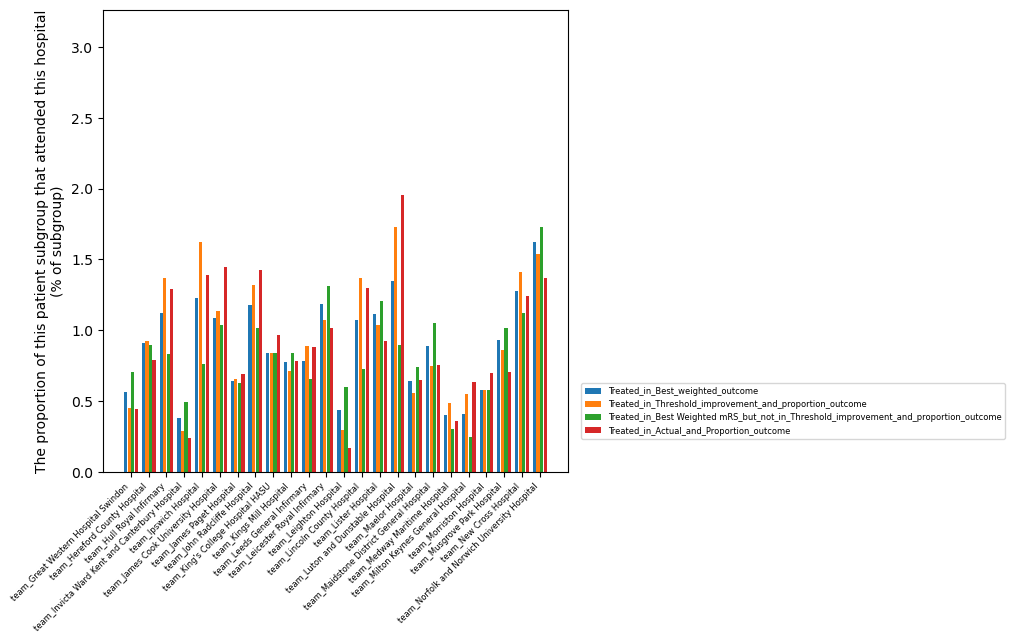

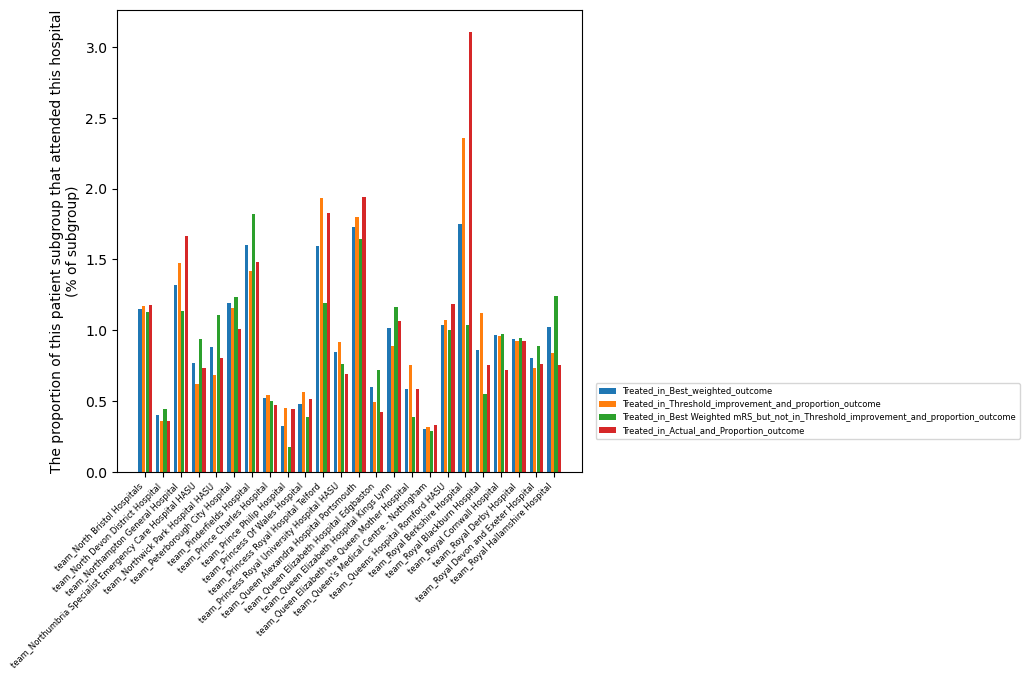

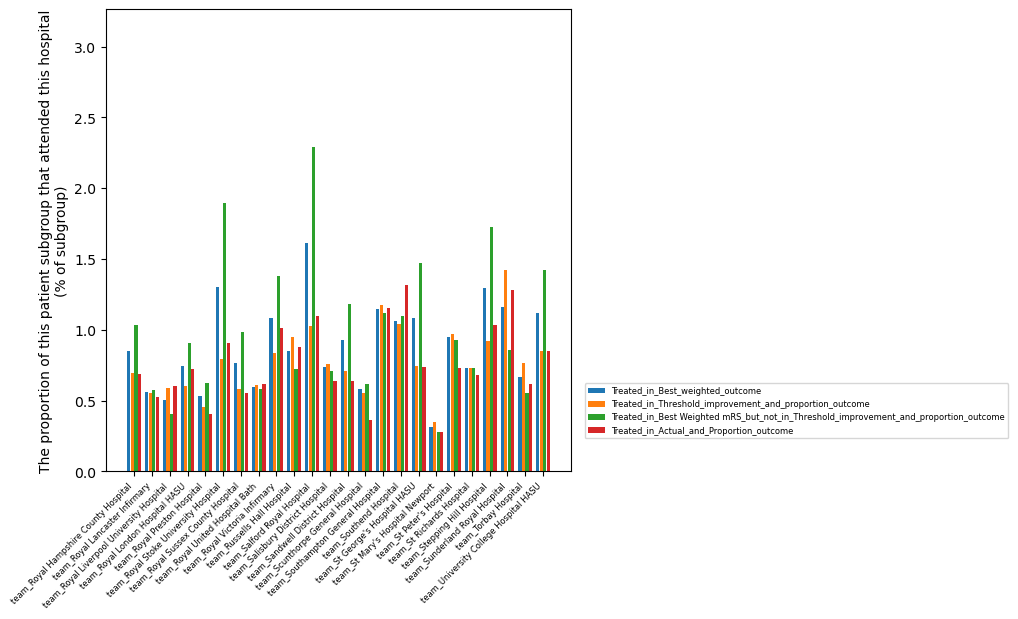

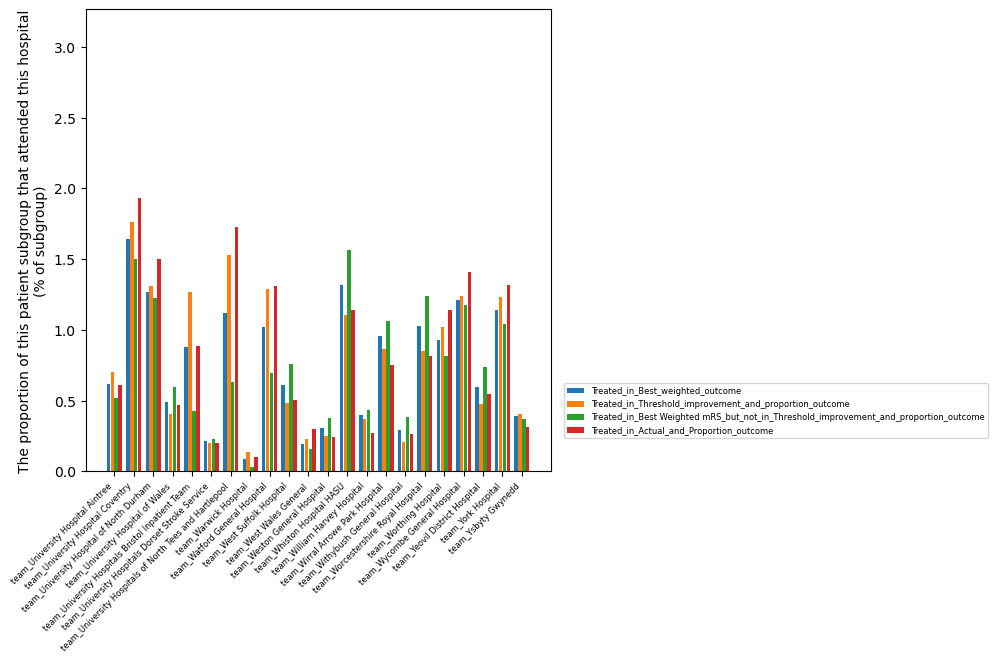

In [ ]:
label = ["Treated_in_Best_weighted_outcome",
         "Treated_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Actual_and_Proportion_outcome"] 

# Get max y value across all subplots, all plots have same range
y_max = df_mean_per_subgroup.loc[ohe_stroke_team_features].max().max()*105

# Set each plot to show 24 hospitals
n_per_plot = 24

# Initialise counters and variables, increment per subplot
ed = 0
count = 0
# While the last hospital plotted is less than total hospitals, create a subplot
while ed < len(ohe_stroke_team_features):
    # Initialise dictionary
    dict_plot = {}
    # Set start and end hospital range
    st = (n_per_plot * count)
    ed = (n_per_plot * (count+1))

    # Make sure last hospital counter isn't beyond final hospital
    ed = min(ed, len(ohe_stroke_team_features))

    # The hosptials to plot
    plot_hospitals = ohe_stroke_team_features[st:ed]

    # Put data to plot in a dictionary
    for l in label:
        dict_plot[l] = df_mean_per_subgroup.loc[plot_hospitals][l] * 100

    # create subplot
    fig, ax = plt.subplots(figsize=(6,6))
    multiple_bar_plot(ax, dict_plot, total_width=.8, single_width=.9)
    plt.xticks(range(len(plot_hospitals)), plot_hospitals, fontsize=6, 
               rotation=45, ha='right')
    plt.ylim(0,y_max)
    plt.ylabel("The proportion of this patient subgroup that attended this"
               " hospital\n(% of subgroup)")
    plt.show()

    count += 1


# NEXT SECTION IS IN PROGRESS

For other features, create a spider/radar/star plot

In [ ]:
selected_features = ["prior_disability", "stroke_severity", "age", 
                     "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]

label = ["Treated_in_Best_weighted_outcome",
         "Treated_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Actual_and_Proportion_outcome"] 

df_radar = pd.DataFrame()
df_radar[label[0]] = df_qu1.loc["mean"]
df_radar[label[1]] = df_qu2.loc["mean"]
df_radar[label[2]] = df_qu3.loc["mean"]
df_radar[label[3]] = df_qu4.loc["mean"]
df_radar.loc[selected_features]

,Treated_in_Best_weighted_outcome,Treated_in_Threshold_improvement_and_proportion_outcome,Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome,Treated_in_Actual_and_Proportion_outcome
prior_disability,1.021414,0.892989,1.171672,0.639262
stroke_severity,9.935828,12.659157,6.749517,12.943534
age,74.319927,74.585356,74.009373,73.133393
onset_to_thrombolysis_time,27.676940,51.115039,0.254232,146.830284
any_afib_diagnosis,0.168799,0.187836,0.146525,0.171090
precise_onset_known,0.676888,0.664919,0.690892,0.800042


### Display results as a spider/radar/star plot

TO DO: Want to adapt the code so that each ax on the radar has its own range of values. Otherwise all set to max 140, and the binary features are not showing on this scale (it seems tricky to make each ax has it's own continuous range)

In [ ]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

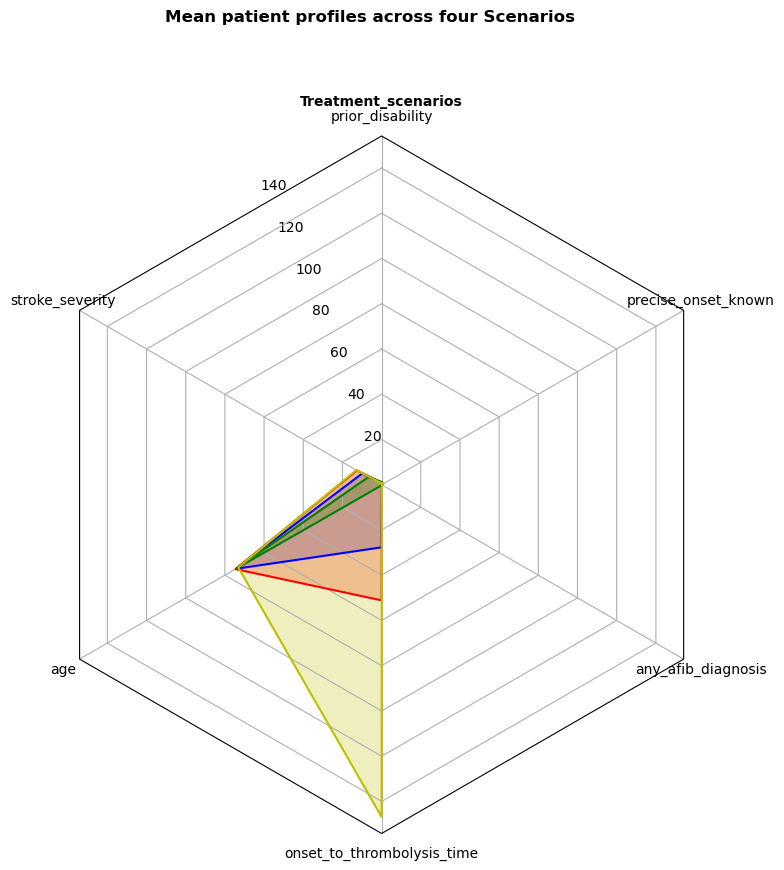

In [ ]:
N = len(selected_features)
theta = radar_factory(N, frame='polygon')

data = [selected_features, ('Treatment_scenarios',df_radar.loc[selected_features].values.T.tolist())]
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'y']
# Plot the four cases from the example data on separate axes
for (title, case_data) in data:
#    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = ("Treated_in_Best_weighted_outcome",
         "Treated_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Actual_and_Proportion_outcome")
#('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')


legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, 'Mean patient profiles across four Scenarios',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

plt.show()

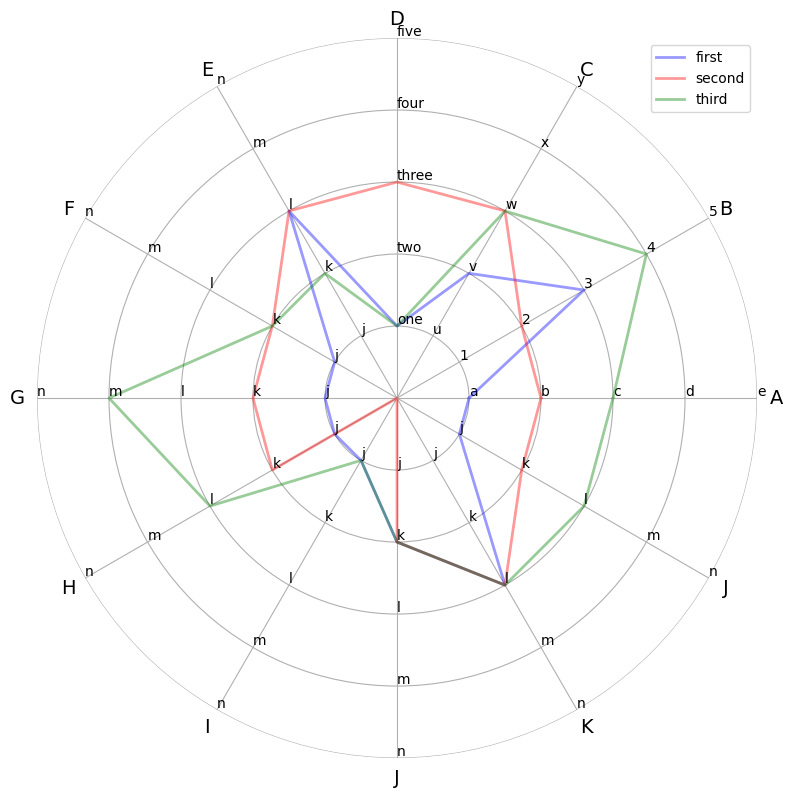

In [ ]:
#!/usr/bin/python

"""
Installation: Get the *Miniconda* Python Distribution - not the Python distrubution from python.org!
- https://conda.io/miniconda.html
Then install modules:
- `cd ~/miniconda3/bin`
- `./conda install numpy pandas matplotlib`
Original source:
- https://stackoverflow.com/questions/24659005/radar-chart-with-multiple-scales-on-multiple-axes
- That code has problems with 5+ axes though
"""

import numpy as np
import matplotlib.pyplot as plt

# Optionally use different styles for the graph
# Gallery: http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
# import matplotlib
# matplotlib.style.use('dark_background')  # interesting: 'bmh' / 'ggplot' / 'dark_background'


class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)

        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid(False)
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines['polar'].set_visible(False)
            ax.set_ylim(0, 5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)


if __name__ == '__main__':
    fig = plt.figure(figsize=(8, 8))

    tit = list('ABCDEFGHIJKJ')  # 12x

    lab = [
        list('abcde'),
        list('12345'),
        list('uvwxy'),
        ['one', 'two', 'three', 'four', 'five'],
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn')
    ]

    radar = Radar(fig, tit, lab)
    radar.plot([1, 3, 2, 1, 3, 1, 1, 1, 1, 2, 3, 1],  '-', lw=2, color='b', alpha=0.4, label='first')
    radar.plot([2, 2, 3, 3, 3, 2, 2, 2, 0, 2, 3, 2], '-', lw=2, color='r', alpha=0.4, label='second')
    radar.plot([3, 4, 3, 1, 2, 2, 4, 3, 1, 2, 3, 3], '-', lw=2, color='g', alpha=0.4, label='third')
    radar.ax.legend()

    fig.savefig('result.png')

In [ ]:
def return_list_of_min_to_max(x):
    l = []
    m = ((x.max() - x.min()) / 2) + x.min()
    l.append(x.min())
    l.append(m)
    l.append(x.max())
    return(l)

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (3).

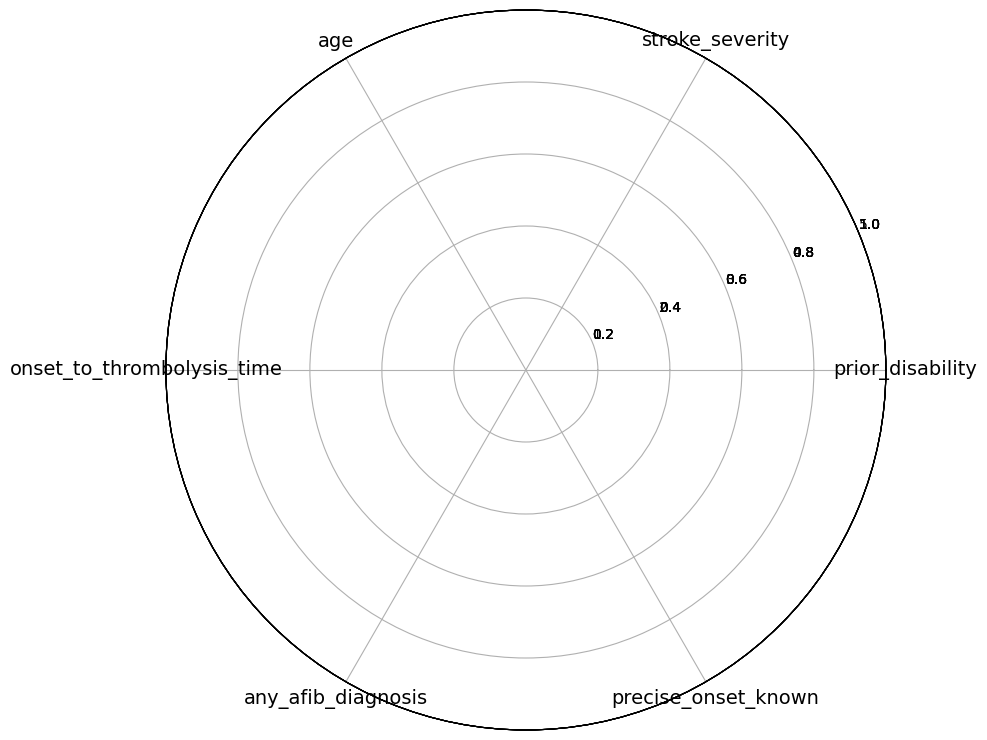

In [ ]:
fig = plt.figure(figsize=(8, 8))

tit = selected_features#list('ABCDEFGHIJKJ')  # 12x

lab = []
for s in selected_features:
    lab.append(return_list_of_min_to_max(df_radar.loc[s]))
#lab = [
#    list('abcde'),
#    list('12345'),
#    list('uvwxy'),
#    ['one', 'two', 'three', 'four', 'five'],
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn')
#]

radar = Radar(fig, tit, lab)
colors = ['b', 'r', 'y', 'g', 'o', 'm']
labels = ("Treated_in_Best_weighted_outcome",
         "Treated_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Actual_and_Proportion_outcome")

for (c, l) in zip(colors, labels):
    d = df_radar.loc[selected_features][l].values
    radar.plot(d,  '-', lw=2, color=c, alpha=0.4, label=l)
#radar.plot([2, 2, 3, 3, 3, 2, 2, 2, 0, 2, 3, 2], '-', lw=2, color='r', alpha=0.4, label='second')
#radar.plot([3, 4, 3, 1, 2, 2, 4, 3, 1, 2, 3, 3], '-', lw=2, color='g', alpha=0.4, label='third')
radar.ax.legend()

#fig.savefig('result.png')

https://towardsdatascience.com/how-to-create-and-visualize-complex-radar-charts-f7764d0f3652

In [ ]:
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable
    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    format_cfg: dict, defaults to None
        A dictionary with formatting configurations
    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=None):
        
        # Default formatting
        self.format_cfg = {
            # Axes
            # https://matplotlib.org/stable/api/figure_api.html
            'axes_args': {},
            # Tick labels on the scales
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.rgrids.html
            'rgrid_tick_lbls_args': {'fontsize':8},
            # Radial (circle) lines
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
            'rad_ln_args': {},
            # Angle lines
            # https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D
            'angle_ln_args': {},
            # Include last value (endpoint) on scale
            'incl_endpoint':False,
            # Variable labels (ThetaTickLabel)
            'theta_tick_lbls':{'va':'top', 'ha':'center'},
            'theta_tick_lbls_txt_wrap':15,
            'theta_tick_lbls_brk_lng_wrds':False,
            'theta_tick_lbls_pad':25,
            # Outer ring
            # https://matplotlib.org/stable/api/spines_api.html
            'outer_ring':{'visible':True, 'color':'#d6d6d6'}
        }
        
        if format_cfg is not None:
            self.format_cfg = { k:(format_cfg[k]) if k in format_cfg.keys() else (self.format_cfg[k]) 
                 for k in self.format_cfg.keys()}        
        
        
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], 
                             polar=True,
                             label = "axes{}".format(i),
                             **self.format_cfg['axes_args']) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=self.format_cfg['incl_endpoint'])
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, 
                                          labels=gridlabel, 
                                          angle=angles[j],
                                          **self.format_cfg['rgrid_tick_lbls_args']
                                         )
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid(**self.format_cfg['rad_ln_args'])
        # Draw outer circle
        self.ax.spines['polar'].set(**self.format_cfg['outer_ring'])
        # Draw angle lines
        self.ax.xaxis.grid(**self.format_cfg['angle_ln_args'])

        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, self.format_cfg['theta_tick_lbls_txt_wrap'], 
                                          break_long_words=self.format_cfg['theta_tick_lbls_brk_lng_wrds'])) for l in labels]
        self.ax.set_xticklabels(labels, **self.format_cfg['theta_tick_lbls'])
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            if a == 0:
                t.set_ha('center')
            elif a > 0 and a < 180:
                t.set_ha('left')
            elif a == 180:
                t.set_ha('center')
            else:
                t.set_ha('right')

        self.ax.tick_params(axis='both', pad=self.format_cfg['theta_tick_lbls_pad'])


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faac091a200>
Traceback (most recent call last):
  File "/home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faac091a200>
Traceback (most recent call last):
  File "/home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/kerry/miniconda3/envs/sam10/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo

NameError: name 'textwrap' is not defined

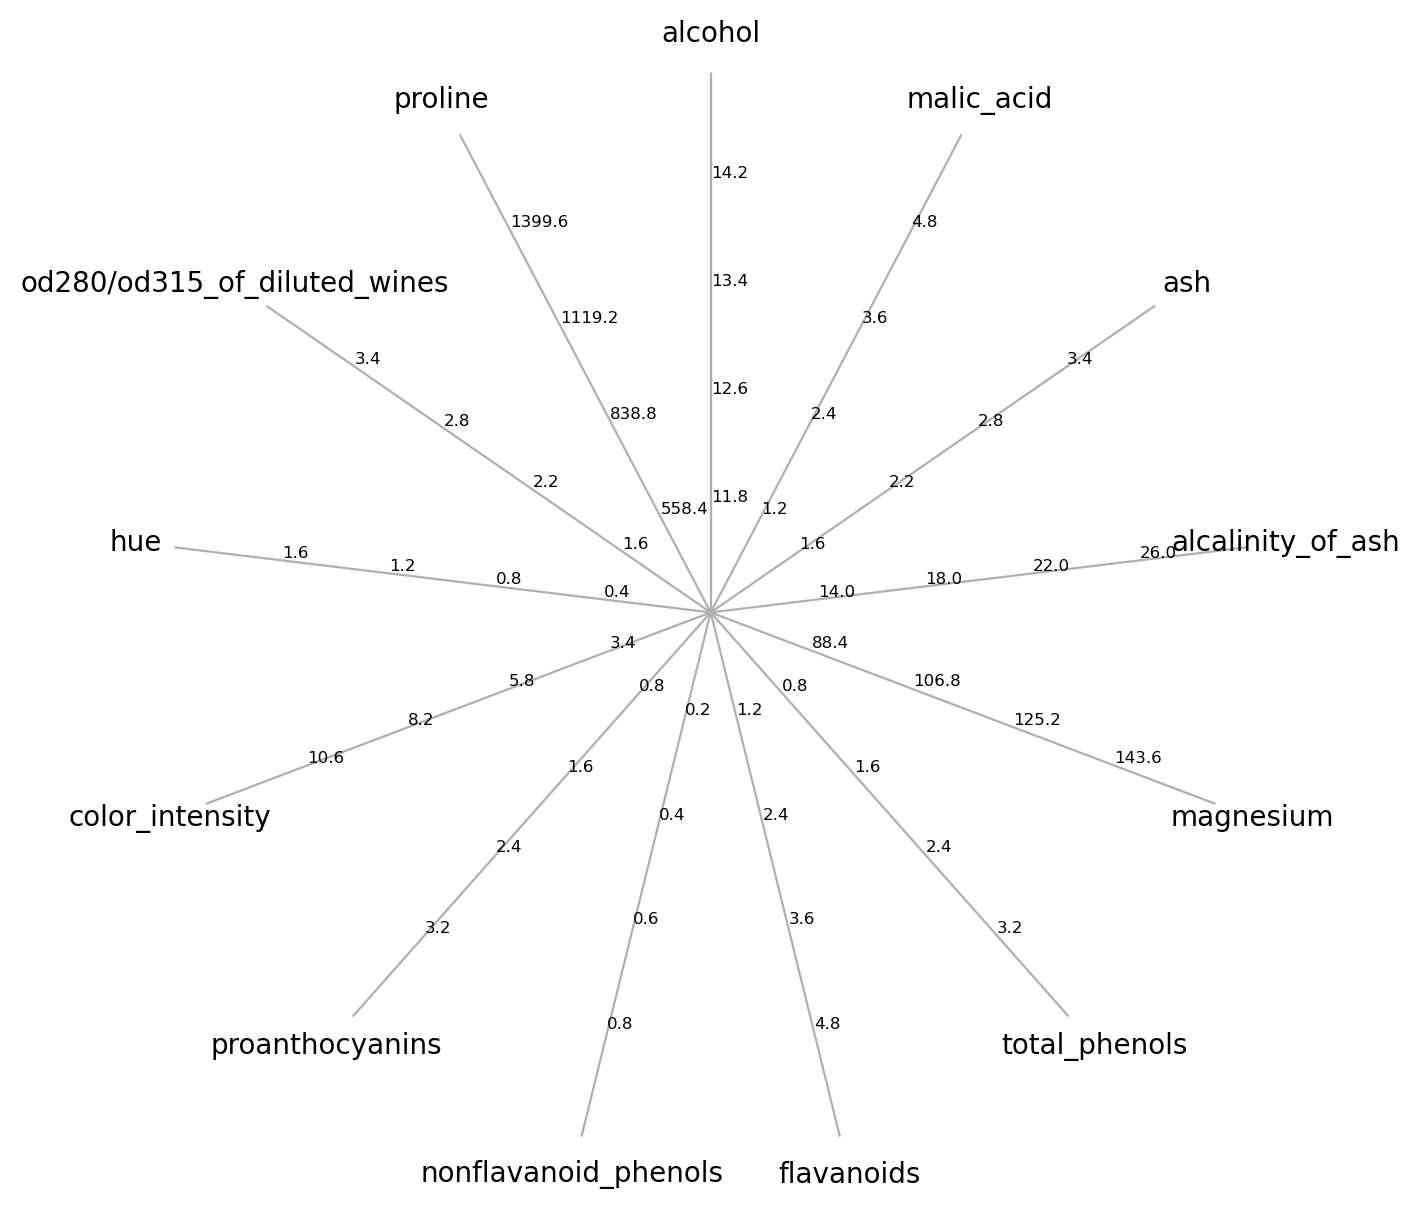

In [ ]:

import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

data = load_wine(as_frame=True)['data']

pipe = make_pipeline(StandardScaler(),
                           KMeans(init="k-means++", n_clusters=3, 
                                  n_init=4, random_state=0)
                          )

data['cluster'] = pipe.fit_predict(data)
result = data.groupby(['cluster']).mean()


min_max_per_variable = data.describe().T[['min', 'max']]
min_max_per_variable['min'] = min_max_per_variable['min'].apply(lambda x: int(x))
min_max_per_variable['max'] = min_max_per_variable['max'].apply(lambda x: math.ceil(x))

variables = result.columns
ranges = list(min_max_per_variable.itertuples(index=False, name=None))   

format_cfg = {
    'rad_ln_args': {'visible':False},
    'outer_ring': {'visible':False},
    'rgrid_tick_lbls_args': {'fontsize':6},
    'theta_tick_lbls': {'fontsize':9},
    'theta_tick_lbls_pad':5
}

fig1 = plt.figure(figsize=(6, 6), dpi=200)
radar = ComplexRadar(fig1, variables, ranges, show_scales=True, format_cfg=format_cfg)

custom_colors = ['#f9b4ab', '#264e70', '#679186']

for g,c in zip(result.index, custom_colors):
    radar.plot(result.loc[g].values, label=f"cluster {g}", color=c)
    #radar.fill(result.loc[g].values, alpha=0.5, color=c)

radar.set_title("Radar chart solution with different scales",pad=50)
plt.show() 

In [ ]:
df_radar.loc[selected_features[0]].tolist()

[1.0214139862824831,
 0.8929889298892989,
 1.1716720318121567,
 0.6392619223855345]

### Save file to be used in notebook 220 to train a XGBoost regression model to predict the predicted shift in mRS due to treatment.

That model will use the same input features as those used in the disability discharge outcome model. We will then fit SHAP values to the mRS shift model.

In [ ]:
data["predicted_mrs_shift_due_to_thrombolysis"] = (
                                    predicted_mrs_shift_due_to_thrombolysis)

filename = os.path.join(paths.data_save_path,
                (paths.notebook + paths.model_text + '_predicted_mrs_shift_due_to_thrombolysis.csv'))
data.to_csv(filename)

***